In [1]:
import time

In [2]:
from sparse_tools_F17 import *
from survey_params import *

model = 'Be13'

sphx_par = spherex_param()
dth = sphx_par.dth
nu_binedges = sphx_par.nu_binedges
nu_bins = sphx_par.nu_bins
line_use = ['Ha', 'OIII', 'Hb', 'OII', 'Lya']
line_name_arr = [r'$H\alpha$', r'$[O\, III]$', r'$H\beta$', r'$[O\, II]$', r'$Ly\alpha$']
nu0_arr = [spec_lines.Ha.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.OIII.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.Hb.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.OII.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.Lya.to(u.GHz, equivalencies=u.spectral()).value]
line_targ_vec = line_use

N_lc = 2500
line_targ_vec = line_use
dOm = (dth * u.arcmin.to(u.rad))**2

sigI0 = 3631 * 10**(-22  /2.5) / 5 / dOm / np.sqrt(4) # pixel NEI
sigI = sigI0 / np.sqrt(4)

In [177]:
def Ivox_from_zsrc2(zsrc_all, dth, nu_binedges, line_use, line_targ, \
                   muL = [], sigL = [], Lratio = [], model = 'Be13', verbose = 0):
    '''
    Given list of source redshift and nu_binedges, calculate the intensity of the light cone.
    
    Inputs:
    =======
    zsrc_all[list]: Nsamp element list, each element is a list of z of source in a lightcone
    dth: pixel size dth^2 [arcmin]
    nu_binedges: [GHz]
    line_use[str list]: list of lines in the light cone
    line_targ[str or str list]: targeting line
    muL: pass to add_line_flux
    sigL: pass to add_line_flux
    Lratio[list]: the intrinsic line luminosity of the individual source is Lratio time Lsrc.
                  Lratio has to be same dimension of zsrc_all. Default: all 1's.

    Outputs:
    ========
    I_vec_all: intensity from all the lines, Nsamp x Nnu array [Jy/sr]
    I_vec_targ: intensity from target lines, Nsamp x Nnu array [Jy/sr]
    '''
    
    
    if type(line_targ) is str:
        if line_targ not in line_use:
            raise ValueError("line_targ must be in line_use.")
    else:
        if not set(line_targ).issubset(line_use):
            raise ValueError("line_targ must be in line_use.")        

    if len(Lratio) != len(zsrc_all) and len(Lratio) !=0:
        raise ValueError('zsrc_all and Lratio does not have the same dimension!!!')

    Nnu = len(nu_binedges) - 1
#     print('zsrc_all[0]:', zsrc_all[0])
    Nset = len(zsrc_all)
#     print('Nset is ', Nset)
    dsr = ((dth * u.arcmin).to(u.rad))**2
    dnus = abs(nu_binedges[1:] - nu_binedges[:-1])
    
    usename = []
    for name in line_use:
        usename.extend(['bin' + name])

    I_vec_all = np.zeros([Nset,Nnu])
    
    if type(line_targ) is str:
        idxtarg = line_use.index(line_targ)
        I_vec_targ = np.zeros([Nset,Nnu])
    else:
        idxtarg_vec = [line_use.index(jj) for jj in line_targ]
        I_vec_targ = np.zeros([len(line_targ),Nset,Nnu])
       
    for i in range(Nset):
        
        if len(zsrc_all[i])==0:
            I_vec_all[i,:] = 0.
            if type(line_targ) is str:
                I_vec_targ[i,:] = 0.
            else:
                I_vec_targ[:,i,:] = 0.
        
        else:
            if len(Lratio) == 0:
                Lri = np.ones(len(zsrc_all[i]))
            elif len(Lratio[i]) != len(zsrc_all[i]):
                raise ValueError('light cone %d zsrc_all and Lratio size not match!!!'%i)
            else:
#                 print('Lratio[i] has shape ', Lratio[i].shape)
#                 print(Lratio[i])
                Lri = Lratio[i]
                
            Lri_arr = np.tile(np.asarray(Lri),(len(line_use),1)).T

            df = pd.DataFrame(zsrc_all[i],columns=['redshift'])
#             print(df)
            _, F_arr = add_line_flux(df, line_use = line_use, muL = muL, sigL = sigL, model = model)
#             print('F_arr')
#             print(F_arr)
            _, bin_arr = add_line_bin(df, nu_binedges, line_use = line_use)
                        
            dnu_arr = np.zeros_like(bin_arr,dtype=float)
            dnu_arr[bin_arr!=-1] = dnus[bin_arr[bin_arr!=-1]]
            I_arr = np.zeros_like(bin_arr,dtype=float)
            I_arr[bin_arr!=-1] = F_arr[bin_arr!=-1] * Lri_arr[bin_arr!=-1]/dnu_arr[bin_arr!=-1] / dsr

            I_vec = np.histogram(bin_arr,bins = np.arange(-0.5,Nnu,1), weights=I_arr)[0]
            I_vec_all[i,:] = I_vec
            
            
            if type(line_targ) is str:
                I_vec = np.histogram(bin_arr[:,idxtarg],bins = np.arange(-0.5,Nnu,1), \
                                     weights=I_arr[:,idxtarg])[0]
                I_vec_targ[i,:] = I_vec
            else:
                
                # for each line, 
                for jj,idxtarg in enumerate(idxtarg_vec):
                    
                    # make a histogram of the bin array for the line, weighted by the I_arr
                    I_vec = np.histogram(bin_arr[:,idxtarg],bins = np.arange(-0.5,Nnu,1), \
                                         weights=I_arr[:,idxtarg])[0]
                    I_vec_targ[jj,i,:] = I_vec
        
        if verbose:
            if (i+1)%100==0:
                print('produce light cone %d/%d (%d %%)'%(i+1,Nset,(i+1)*100./Nset))
    
    return I_vec_all,I_vec_targ

def gen_Ipred2(z_coords, N_arr, dth, nu_binedges, line_use, line_targ, model = 'Be13',
              muL = [], sigL = [], verbose = 0):
    '''
    Generate I_arr with the N_arr from sparse approx.
    
    Inputs:
    =======
    z_coords[arr]: Nsamp element list, each element is a list of z of source in a lightcone
    N_arr[arr, Nset x len(z_coords)]: 
    dth: pixel size dth^2 [arcmin]
    nu_binedges: [GHz]
    line_use[str list]: list of lines in the light cone
    line_targ[str or str list]: targeting line
    '''

    Nsamp, Nz = N_arr.shape
     
    if Nz != len(z_coords):
        raise ValueError('N_arr 2nd dimension does not match len(z_coords).')
    
    zsrc_all = []
    Lratio = []
    for i in range(Nsamp):
        zsrc_all.append(z_coords)
        Lratio.append(N_arr[i,:])
        
#     print('line ratio has shape: ', np.array(Lratio).shape)
#     print(Lratio)
        
#     print('zsrc_all:', zsrc_all)
#     print('nu binedges has length ', len(nu_binedges))
#     print(nu_binedges)
#     
#     print('line use is ', line_use)
#     print('line_targ is ', line_targ)
        
    Ipred_all, Ipred_targ = Ivox_from_zsrc2(zsrc_all, dth, nu_binedges, \
                    line_use, line_targ, Lratio = Lratio, model = model,
                                           muL=muL, sigL=sigL, verbose = 0)
    
    return Ipred_all, Ipred_targ

In [150]:
print(spec_lines.Ha.to(u.GHz, equivalencies=u.spectral()).value)

456791.7994819443


In [905]:
from matplotlib import cm
from scipy.signal import find_peaks

class sphx_test():
    
    model = 'Be13'
    
    def __init__(self, nsig_th=0.97):
        self.sphx_par = spherex_param()
        self.nsig_th = nsig_th
        
        self.dOm = (self.sphx_par.dth * u.arcmin.to(u.rad))**2
        
        self.line_use = ['Ha', 'OIII', 'Hb', 'OII', 'Lya']
        self.line_targ_vec = self.line_use.copy()

        self.line_name_arr = [r'$H\alpha$', r'$[O\, III]$', r'$H\beta$', r'$[O\, II]$', r'$Ly\alpha$']
        self.nu0_arr = [spec_lines.Ha.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.OIII.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.Hb.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.OII.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.Lya.to(u.GHz, equivalencies=u.spectral()).value]
        self.sigI0 = 3631 * 10**(-22 / 2.5) / 5 / self.dOm / np.sqrt(4) # pixel NEI
        self.sigI = self.sigI0 / np.sqrt(4)
        self.e_th = self.sigI * self.nsig_th # normally * 0.97

        
        
    def load_dictionary(self, filename='data_internal/sparse_be13_dict.pickle'):
        
        with open(filename,'rb') as pfile:
            self.A, self.I_norm, self.z_coords, self.N_nu, self.N_z, \
                        self.z_coords_all, self.z_idx, self.I_coords_all = pickle.load(pfile)
                
    def load_observations(self, filename='data_internal/sparse_be13_general_Lr.pickle'):
        with open(filename,'rb') as pfile:
            self.N_true, self.Itrue_all, self.Itrue_targ = pickle.load(pfile)
            
        self.noise = np.random.normal(0, self.sigI, self.Itrue_all.shape)

          
    def sim_noise(self, nsims=10, N_lc=None, iter_max= 10, verbose=False, show_iter_plots=False, stochastic=False, \
                 fast_lines=False, amp_nsigma=5.):
        
        
        if N_lc is None:
            N_lc = self.Itrue_all.shape[0]
            
        if type(N_lc)==list:
            print("sim got a list")
            n_lc = len(N_lc)
        else:
            n_lc = N_lc
            
        f_arrs = []
        iter_counts = []
        Ipred_targ_arr = np.zeros([nsims, len(self.line_use), n_lc, self.Itrue_all.shape[-1]])
        print('Ipred targ has shape ', Ipred_targ_arr.shape)

        if stochastic:
            Iobs_all = self.Itrue_all + self.noise
            
            if type(N_lc)==list:
                Iobs_specific_lines = Iobs_all[np.array(N_lc)]
            else:
                Iobs_specific_lines = Iobs_all[:N_lc]
            print('specific lines has shape', Iobs_specific_lines.shape)

            
            for i in range(nsims):
                npred, ipredtarg, idx_order, f_arr, iter_cts = self.run_MP_ampth(Iobs_all, N_lc=N_lc, iter_max=iter_max, return_Ipred_targ=True,\
                                            verbose=verbose, show_iter_plots=show_iter_plots, realization_noise=self.noise, \
                                           stochastic=stochastic, fast_lines=fast_lines, amp_nsigma=amp_nsigma)
            
                Ipred_targ_arr[i] = ipredtarg
                
                f_arrs.append(f_arr)
                iter_counts.append(iter_cts)
            
                if n_lc > 100:
                    print('i = ', i)
            
        
        else:
            for i in range(nsims):
                if nsims > 1:
                    noise = np.random.normal(0, self.sigI, self.Itrue_all.shape)
                    Iobs_all = self.Itrue_all + noise
                else:
                    Iobs_all = self.Itrue_all + self.noise
                    
                if type(N_lc)==list:
                    Iobs_specific_lines = Iobs_all[np.array(N_lc)]
                else:
                    Iobs_specific_lines = Iobs_all[:N_lc]
                print('specific lines has shape', Iobs_specific_lines.shape)

                    
                npred, ipredtarg, idx_order, f_arr, iter_cts = self.run_MP_ampth(Iobs_all, N_lc=N_lc, iter_max=iter_max, return_Ipred_targ=True,\
                                                verbose=verbose, show_iter_plots=show_iter_plots, realization_noise=self.noise, \
                                               stochastic=stochastic, fast_lines=fast_lines, amp_nsigma=amp_nsigma)

                Ipred_targ_arr[i] = ipredtarg
                
                f_arrs.append(f_arr)
                iter_counts.append(iter_cts)

            
        return Ipred_targ_arr, f_arrs, iter_counts, Iobs_specific_lines
    
    def run_MP_ampth(self, Iobs_all, N_lc=None, A=None, I_norm=None, I_norm_divfac=4, e_th=None, iter_max = 10, stochastic=False,\
                verbose=False, return_Ipred_targ=False, show_iter_plots=False, realization_noise=None, fast_lines=True, \
               amp_nsigma=5., nstrikes=3):

        
        if N_lc is None:
            N_lc = Iobs_all.shape[0] # number of light curves
            
        if type(N_lc)==list:
            n_lc = len(N_lc)
        else:
            n_lc = N_lc
            
        if e_th is None:
            e_th = self.e_th
            
        idx_order, iter_cts = [], []

        N_nu, N_z = self.A.shape # number of frequency channels, number of redshifts?
        N_pred = np.zeros([n_lc, N_z]) # predicted N, number of light cones x number of redshift bins

        if verbose:
            print('N_nu, N_z:', N_nu, N_z)
            print('N_lc:', n_lc)
            
        f_arr_lines = []
            
        if fast_lines:
            
            t0 = time.time()
            eth_bool_array = np.zeros((n_lc)) # threshold boolean array for each sight line
            iter_count = 0 # number of iterations
            all_R_arrs = Iobs_all[:N_lc].copy() # copy the number of lines we're dealing with 
            all_f_arrs = np.zeros_like(all_R_arrs) # this will hold the reconstructions
            
            all_NI_arr = np.zeros([N_lc, N_z]) # this has effective number counts
            
            # run while loop until all light curves have reached threshold or when iter counter reaches max

            while np.sum(eth_bool_array) < Iobs_all.shape[0] and iter_count < iter_max:
                # the big dot product is between the simulated data matrix (N_sightlines x N_nu) and the template
                # (N_templates x N_nu) transpose A^T , so we end up with (N_sightlines x N_templates) which contains the 
                # inner products of the templates with each sightline
                iter_count += 1
                big_dotprod = np.dot(all_R_arrs, self.A)

                # choose the argmax for each sightline 
                all_gammas = np.argmax(big_dotprod, axis=1) # indices of the chosen templates for each sightline

                # compute amplitudes of the templates 
                all_amp = np.array([np.sum(self.A[:,all_gammas[i]] * all_R_arrs[i]) for i in range(N_lc)])
                
                # all_u should be the added template for all sightlines, so N_lc x N_nu
                all_u = np.array([all_amp[i] * self.A[:,all_gammas[i]] for i in range(N_lc)])

                all_f_arrs[~eth_bool_array.astype(np.bool)] += all_u[~eth_bool_array.astype(np.bool)]
                all_R_arrs[~eth_bool_array.astype(np.bool)] -= all_u[~eth_bool_array.astype(np.bool)]

                # compute RMS and determine which are below threshold
                all_R = np.array([np.sqrt(np.mean(R_arr**2, axis=0)) for R_arr in all_R_arrs])

                eth_bool_array[all_R < e_th] = 1
            
                t1 = time.time()
            
                for i in range(N_lc):
                    if not eth_bool_array[i]:
                        all_NI_arr[i,all_gammas[i]] += all_amp[i]
                
                print('time for dumb loop is ', time.time()-t1)

                
            print('out of the while loop')
            N_pred = all_NI_arr / (self.I_norm / I_norm_divfac)
            print('time elapsed for fast version is ', time.time()-t0)

            if return_Ipred_targ:
                _, Ipred_targ = gen_Ipred(self.z_coords, N_pred, self.sphx_par.dth*2, self.sphx_par.nu_binedges,\
                                       self.line_use, self.line_targ_vec, model = self.model, verbose = verbose)

    #             print('Ipred targ has shape', Ipred_targ.shape)
                print(N_pred.shape, Ipred_targ.shape, idx_order, all_f_arrs.shape, iter_cts)
                return N_pred, Ipred_targ, idx_order, all_f_arrs, iter_cts
                
        else:
                
            t0 = time.time()

            if type(N_lc)==list:
                iter_range = N_lc
            else:
                iter_range = np.arange(N_lc)
                
            for i, ilc in enumerate(iter_range):
                

                idx_ord = []
                R_arr = Iobs_all[ilc].copy()

                if verbose:
                    print('R_arr:', R_arr)
                R = np.sqrt(np.mean(R_arr**2)) # the initial residual is the RMS of the component
                f_arr, NI_arr = np.zeros(N_nu), np.zeros(N_z)

                iter_count = 0
                ntry = 0
                # start the MP algorithm
                while True:
                    if verbose:
                        print('top of while loop')
                    # if residual is less than epsilon threshold or iteration counter reaches max, end it
                    if iter_count == iter_max:
                        break
                        
                    dotprod = np.dot(R_arr.reshape(1, -1), self.A)[0]
                    nsort = 10
                    
                    ind = np.argpartition(dotprod, -nsort)[-nsort:]

                    # choose the dictionary element with the largest inner product
                    if stochastic:
                        probs = dotprod[ind] / np.sum(dotprod[ind])
                        gamma = np.random.choice(ind, p=probs)
                        
                        amp = np.sum(self.A[:,gamma] * R_arr)
                        
                        if amp < amp_nsigma*self.sigI:
                            if ntry < nstrikes:
                                ntry += 1
                                if verbose:
                                    print('ntry is now ', ntry, ' going to top of while loop, ', amp, amp_nsigma*self.sigI)
                                continue
                                    
                            else: # if you run out of tries, then just look at largest dot product and check that
                                if verbose:
                                    print('ran out of strikes, trying largest dot product')
                                gamma = np.argmax(dotprod)
                                amp = np.sum(self.A[:,gamma] * R_arr)
                                # if amplitude is still smaller than threshold, then we're done. otherwise, we choose it
                                if amp < amp_nsigma*self.sigI:
                                    if verbose:
                                        print('largest dot product still smaller, breaking ', amp, amp_nsigma*self.sigI)
                                    break
                                    
                        # once we find one that works, add it to the idx_order array and reset the stochastic counter
                        if verbose:
                            print('found one that works, ', gamma, amp, amp_nsigma*self.sigI)
                        idx_ord.append(gamma)
                        ntry = 0
                    
                    else:
                        gamma = np.argmax(dotprod) # this is the index of the template
                        idx_ord.append(gamma)

                        amp = np.sum(self.A[:,gamma] * R_arr)
                        
                        if amp < amp_nsigma*self.sigI:
                            break

                    iter_count += 1

                    # multiply the amplitude by the normalized template
                    u = amp * self.A[:,gamma]

                    if show_iter_plots:
                        
                        self.plot_model_iter(R_arr, u, e_th, ilc, iter_count, gamma, realization_noise=realization_noise)
                    
                    NI_arr[gamma] += amp
                    # subtract largest inner product from residual
                    R_arr -= u
                    f_arr += u
                    R = np.sqrt(np.mean(R_arr**2))
                
                N_pred[i,:] = NI_arr / (self.I_norm / I_norm_divfac)

#                 N_pred[ilc,:] = NI_arr / (self.I_norm / I_norm_divfac)
                iter_cts.append(iter_count)
                idx_order.append(idx_ord)
                f_arr_lines.append(f_arr)
            
            
            print('f_arr_lines has shape ', np.array(f_arr_lines).shape)
        
            if verbose:
                print('time elapsed for slow version is ', time.time()-t0)
                print('N_pred has shape ', N_pred.shape)
                print(N_pred)
            if return_Ipred_targ:
                _, Ipred_targ = gen_Ipred(self.z_coords, N_pred, self.sphx_par.dth*2, self.sphx_par.nu_binedges,\
                                       self.line_use, self.line_targ_vec, model = self.model, verbose = verbose)

#                 print('Ipred targ has shape', Ipred_targ.shape)
                return N_pred, Ipred_targ, idx_order, f_arr_lines, iter_cts

        return N_pred
    
    def plot_model_iter(self, R_arr, u, e_th, ilc, iter_count, gamma, realization_noise=None):
        
        plt.figure()
        plt.title('Iteration '+str(iter_count)+': Template index = '+str(gamma)+' z='+str(np.round(self.z_coords[gamma], 2)))
        plt.plot(np.arange(len(R_arr)), R_arr, color='k', linewidth=2, label='current residual')
        plt.plot(np.arange(len(u)), u, color='r', linewidth=1, label='chosen template')
        if realization_noise is not None:
            plt.plot(np.arange(len(u)), realization_noise[ilc], color='b', linestyle='dashed', label='noise')
        plt.axhline(-e_th, color='k', linewidth=5)
        plt.axhline(e_th, color='k', linewidth=5)
        plt.xlabel('Frequency bin index')
        plt.ylabel('Intensity')
        plt.legend()
        plt.show()
    
    def show_result1(self, Ipred_targ_arr, N_lc=None, stochastic=False):
        
        if N_lc is None:
            N_lc = Ipred_targ_arr.shape[2]
        nu0_arr = [spec_lines.Ha.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.OIII.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.Hb.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.OII.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.Lya.to(u.GHz, equivalencies=u.spectral()).value]

        fig, ax = plt.subplots(5, 1, figsize = (10,25))

        # for each spectral line/array...
        for jtarg, (nu0, line_name) in enumerate(zip(self.nu0_arr, self.line_name_arr)):
            
            # redshift bins obtained by rest frame divided by observed frequency - 1
            zbins = nu0 / self.sphx_par.nu_bins - 1
            
            # we know what the true mean intensity is for the light cones we choose
            mu_true = np.mean(self.Itrue_targ[jtarg,:N_lc,:], axis=0)
            ax[jtarg].plot(zbins, mu_true, 'ko-', markersize = 5, lw = 2)
            
            # compute mean across light cones
            mus_pred = np.mean(Ipred_targ_arr[:,jtarg,:N_lc,:], axis = 1)
            # then take mean and standard deviation across realizations
            mu_pred = np.mean(mus_pred, axis = 0)
            sig = np.std(mus_pred, axis = 0)
            # plot them!
            ax[jtarg].errorbar(zbins, mu_pred, sig, c = 'r', fmt = 'none', capsize = 2, lw = 3)
            if stochastic:
                ax[jtarg].set_title(line_name+' (stochastic MP)', fontsize = 20)
            else:
                ax[jtarg].set_title(line_name, fontsize = 20)

            ax[jtarg].tick_params(axis='both', which='major', labelsize=15)
            ax[jtarg].set_ylabel('I [Jy/sr]', fontsize = 20)
        ax[4].set_xlabel('z', fontsize = 20)
        fig.tight_layout()
        return fig
        
        
    def plot_correlation_coeffs_sphx(self, Ipred_targ_arr, N_lc=None, return_fig=False):
    
        if N_lc is None:
            N_lc = Ipred_targ_arr.shape[2]
        fig, ax = plt.subplots(1, 1, figsize = (15,7))

        mucntot_arr = np.array([])
        sigcntot_arr = np.array([])
        ztot_arr = np.array([])
        
        for jtarg in range(len(x.line_use)):
            nu0 = nu0_arr[jtarg]
            zbins = nu0 / sphx_par.nu_bins - 1
            sp = np.where(zbins < 10)[0]
            mucp_arr, sigcp_arr, mucn_arr, sigcn_arr = [np.zeros(self.N_nu) for x in range(4)]
            for iband in range(self.N_nu):
                cp_arr, cn_arr = [np.zeros(Ipred_targ_arr.shape[0]) for x in range(2)]
                for isim in range(Ipred_targ_arr.shape[0]):
                    mapt = self.Itrue_targ[jtarg, :N_lc, iband]
                    mapp = Ipred_targ_arr[isim, jtarg, :N_lc, iband].copy()
                    mapn = np.random.normal(size = mapt.shape)
                    mapt -= np.mean(mapt)
                    mapp -= np.mean(mapp)
                    mapn -= np.mean(mapn)
                    if np.sum(mapt**2) > 0 and np.sum(mapp**2) > 0:
                        cp_arr[isim] = np.sum(mapt * mapp) / np.sqrt(np.sum(mapt**2) * np.sum(mapp**2))
                    if np.sum(mapt**2) > 0 and np.sum(mapn**2) > 0:
                        cn_arr[isim] = np.sum(mapt * mapn) / np.sqrt(np.sum(mapt**2) * np.sum(mapn**2))
                mucp_arr[iband] = np.mean(cp_arr)
                sigcp_arr[iband] = np.std(cp_arr)
                mucn_arr[iband] = np.mean(cn_arr)
                sigcn_arr[iband] = np.std(cn_arr)

            mucntot_arr = np.concatenate((mucntot_arr, mucn_arr[sp]))
            sigcntot_arr = np.concatenate((sigcntot_arr, sigcn_arr[sp]))
            ztot_arr = np.concatenate((ztot_arr, zbins[sp]))
            ax.fill_between(zbins[sp],mucp_arr[sp] - sigcp_arr[sp], mucp_arr[sp] + sigcp_arr[sp],\
                            label = line_name_arr[jtarg], alpha = 0.6)
        sortidx = ztot_arr.argsort()
        ax.fill_between(ztot_arr[sortidx], mucntot_arr[sortidx] - sigcntot_arr[sortidx],\
                        mucntot_arr[sortidx] + sigcntot_arr[sortidx], alpha=0.6, facecolor='gray')
        ax.legend(loc = 0, fontsize = 20)
        ax.set_xlabel('z', fontsize = 20)
        ax.set_xlim([0,10])
        ax.set_ylabel(r'correlation coeff. r', fontsize = 20)
        ax.set_xticks(np.arange(10))
        ax.tick_params(axis='both', which='major', labelsize=15)

        if return_fig:
            return fig
        
        
    def Ipred_targ_redshift_covariance(self, Ipred_targ_arr, line_name_array, f_arr_pred=None, ilc_idx=None, nsigth=5, return_fig=True, zoom=True):
    
    #     list_of_covariance_mats = [[] for i in range(Ipred_targ_arr.shape[1])]
        nu0_array = [spec_lines.Ha.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.OIII.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.Hb.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.OII.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.Lya.to(u.GHz, equivalencies=u.spectral()).value]

        sum_covariances = []
        
        list_of_template_idxs = []

        fig = plt.figure(figsize=(7, 8))
#         plt.suptitle('$\\sum_{n=1}^{N_{lc}}\\mathcal{C}_n(I_{z_i},I_{z_j})$, '+str(nsigth)+'$\\sigma$ stopping threshold', fontsize=20)
        plt.suptitle('$\\rho(I_{z_i},I_{z_j})$, '+str(nsigth)+'$\\sigma$ stopping threshold', fontsize=20, y=1.05)

        
        nothin_counter = False
        for line_idx in range(Ipred_targ_arr.shape[1]-1):

            zbins = nu0_array[line_idx] / self.sphx_par.nu_bins - 1
#             print(zbins)

            list_of_covariance_mats = []
            
            if len(Ipred_targ_arr.shape)==3:
                data_matrix = np.zeros((Ipred_targ_arr.shape[0], Ipred_targ_arr.shape[-1]))
                for n in range(Ipred_targ_arr.shape[0]):
                    data_matrix[n,:] = Ipred_targ_arr[n, line_idx]

                    
            else:
                for ilc in range(Ipred_targ_arr.shape[2]):
                    data_matrix = np.zeros((Ipred_targ_arr.shape[0], Ipred_targ_arr.shape[-1]))
                    for n in range(Ipred_targ_arr.shape[0]):
                        data_matrix[n,:] = Ipred_targ_arr[n, line_idx,ilc]

            covariance_mat = np.cov(data_matrix.transpose())


            if np.sum(np.abs(covariance_mat))>0.1:

                list_of_covariance_mats.append(covariance_mat)

            sum_covariance = np.nansum(np.array(list_of_covariance_mats), axis=0)
            sum_covariances.append(sum_covariance)
            plt.subplot(2,2,line_idx+1)
#             plt.subplot(1,Ipred_targ_arr.shape[1]-1,line_idx+1)
            plt.title(line_name_array[line_idx], fontsize=16)
            select_idxs = None
            if len(list_of_covariance_mats) > 0:
                
                print('sum_cov.shape[0]:', sum_covariance.shape[0])
                for j in range(sum_covariance.shape[0]):
                    for n, idxs in enumerate(np.nonzero(sum_covariance[j])):
                        if len(idxs) > 1:
                            select_idxs = idxs
                            nothin_counter = True
                            break
                            
                print('select idxs is ', select_idxs) 
#                 print(np.nonzero(sum_covariance[j])[n])

                if select_idxs is not None:
                    sum_cov_zoom = sum_covariance[select_idxs]
                    sum_cov_zoom = sum_cov_zoom[:, select_idxs]
                
                    sum_corr_zoom = np.array([[sum_cov_zoom[i,j]/np.sqrt(sum_cov_zoom[i,i]*sum_cov_zoom[j,j]) for i in range(sum_cov_zoom.shape[0])] for j in range(sum_cov_zoom.shape[1])])
                
#                 print(sum_cov_zoom)
#                 plt.imshow(sum_cov_zoom, vmin=np.min(sum_cov_zoom), vmax=np.max(sum_cov_zoom), origin='lower')
                    plt.imshow(sum_corr_zoom, vmin=-1, vmax=1, origin='lower', cmap='bwr')
                else:
                    plt.imshow(np.zeros((2,2)), cmap='bwr')
#                 plt.imshow(sum_cov_zoom, vmin=np.percentile(sum_cov_zoom, 15), vmax=np.percentile(sum_cov_zoom, 95), origin='lower')

                
                plt.xlabel('$z$', fontsize=16)
                plt.ylabel('$z$', fontsize=16)
#                 tick_idxs = np.array([0, 20, 40, 60, 80])
#                 mask = (tick_idxs > min_idx)*(tick_idxs < max_idx)
#                 tick_idxs = tick_idxs[mask]
                
                if zoom and select_idxs is not None:
                    plt.xticks(np.arange(len(select_idxs)), np.round(zbins[select_idxs], 2))
                    plt.yticks(np.arange(len(select_idxs)), np.round(zbins[select_idxs], 2))


#                     plt.yticks(tick_idxs, np.round(zbins[tick_idxs], 1))
                
                
#                 plt.imshow(sum_covariance, vmin=np.percentile(sum_covariance, 15), vmax=np.percentile(sum_covariance, 95), origin='lower')
                cbar = plt.colorbar(orientation='horizontal')
#                     cbar.set_label('[Jy$^2$/sr$^2$]', fontsize=16)
            list_of_template_idxs.append(select_idxs)
#             plt.xlabel('$z$', fontsize=16)
#             plt.ylabel('$z$', fontsize=16)
#             tick_idxs = np.array([0, 20, 40, 60, 80])
#             plt.xticks(tick_idxs, np.round(zbins[tick_idxs], 1))
#             plt.yticks(tick_idxs, np.round(zbins[tick_idxs], 1))

        if not nothin_counter:
            plt.close()
            fig = None
        else:
            plt.tight_layout()
            plt.show()
            
        f = None
        
        if nothin_counter:
            colors = ['C0', 'C1', 'C2', 'C3', 'C4']
            markers = ['o', '*', 'v', 'x', '+', '^', 'v', 'x', '+', '^']
            if ilc_idx is not None:
                f, axes = plt.subplots(5, 1, sharex=True, figsize=(10, 14))
            else:
                f, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 12))
#             plt.figure(figsize=(10, 10))
            for line_idx in range(Ipred_targ_arr.shape[1]-1):
                if list_of_template_idxs[line_idx] is not None:
                    cmap = cm.get_cmap('viridis')
                    redshifts = zbins[np.array(list_of_template_idxs[line_idx])]
                    normredshifts = np.arange(len(redshifts))/len(redshifts)
#                     normredshifts = redshifts/np.max(redshifts)
                    
#                     print(normredshifts)
                    cmap_colors = cmap(normredshifts)
            
                    zbins = nu0_array[line_idx] / self.sphx_par.nu_bins - 1

#                 plt.subplot(4,1,line_idx+1)
#                 plt.title(self.line_name_arr[line_idx], fontsize=16)
                if list_of_template_idxs[line_idx] is not None:
                    all_nonz_A = []
            
                    xtextpos = []
                    ytextpos = []
            
                    for n, tidx in enumerate(list_of_template_idxs[line_idx]):
                        
                        label = 'z = '+str(np.round(zbins[tidx], 2))
#                         plt.plot(np.arange(self.A.shape[0]), self.A[:,self.A.shape[0]*line_idx+tidx],label=label, color=colors[line_idx], alpha=0.2)
                        axes[line_idx].plot(np.arange(self.A.shape[0]), self.A[:,self.A.shape[0]*line_idx+tidx],label=label, color=cmap_colors[n])
                        
                        axes[line_idx].legend(fontsize=10)

                        A_vec =  self.A[:,self.A.shape[0]*line_idx+tidx]
                        nonz_A = np.where(A_vec > 0.)[0]
                        peaks, _ = find_peaks(A_vec, height=0)
                        
#                         all_nonz_A.extend(nonz_A)
#                         plt.scatter(nonz_A, A_vec[nonz_A], marker=markers[n], color=colors[line_idx])
#                         offsets = np.arange(len(nonz_A))-np.mean(np.arange(len(nonz_A)))
#                         print(offsets)
                        for pidx, peak in enumerate(peaks):
                            fac = 0.0
                            if peak in xtextpos:
#                                 print('peak is in xtextpos!')
                                fac = 0.1
                                if A_vec[peak] in ytextpos:
#                                     print('y val is too!')
                                    fac = 0.1
                            
#                             axes[line_idx].text(peak, fac+A_vec[peak], label, fontsize=11)
                            xtextpos.append(peak)
                            ytextpos.append(A_vec[peak])

#                         plt.scatter(nonz_A, A_vec[nonz_A], marker=markers[n], s=200, color=colors[line_idx])
#                 plt.xlim(np.min(all_nonz_A)-5)
#                 if line_idx == Ipred_targ_arr.shape[1]-1:
                axes[line_idx].set_xlabel('$\\nu$ index', fontsize=12)
#                 axes[line_idx].set_ylim(0, 1.1)
                axes[line_idx].text(75, 0.65, self.line_name_arr[line_idx], fontsize=24)
            
            if ilc_idx is not None:
                axes[4].plot(np.arange(self.A.shape[0]), self.Itrue_all[ilc_idx], color='k', label='truth')
                axes[4].plot(np.arange(self.A.shape[0]), np.median(f_arr_pred, axis=0), color='b', label='pred')
                axes[4].fill_between(np.arange(self.A.shape[0]), np.percentile(f_arr_pred, 16, axis=0), np.percentile(f_arr_pred, 84, axis=0), color='b', alpha=0.5)
        
            plt.tight_layout()
            plt.show()
            
        
        if return_fig:
            return fig, f, sum_covariances
        
        return sum_covariances



In [906]:
x = sphx_test(nsig_th=1.0)
x.load_dictionary()
x.load_observations()

/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


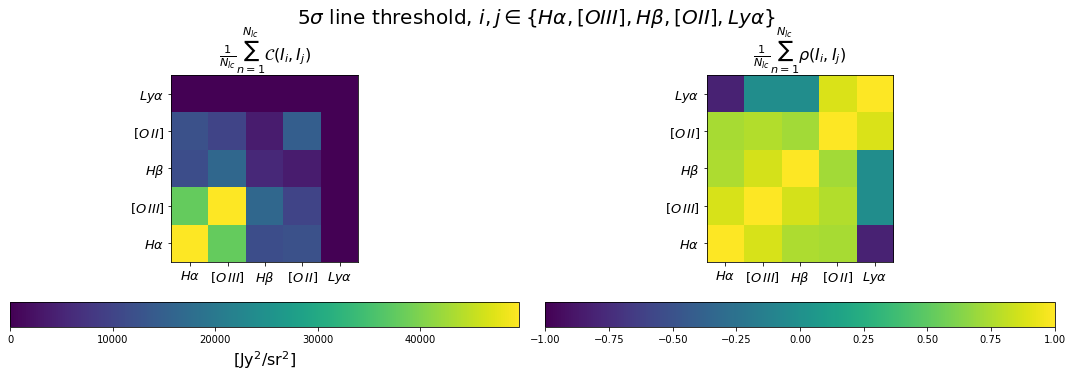

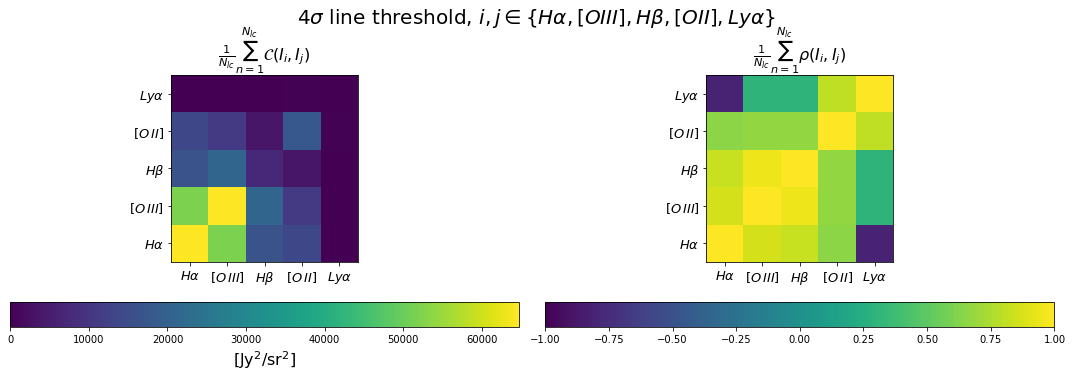

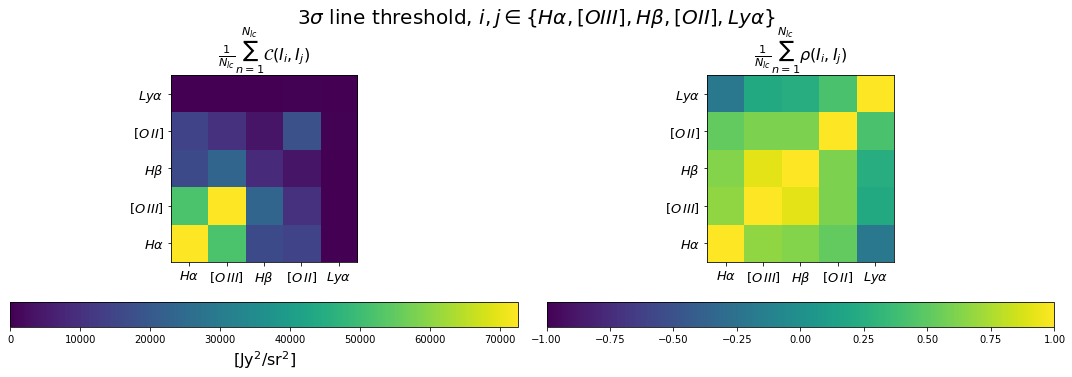

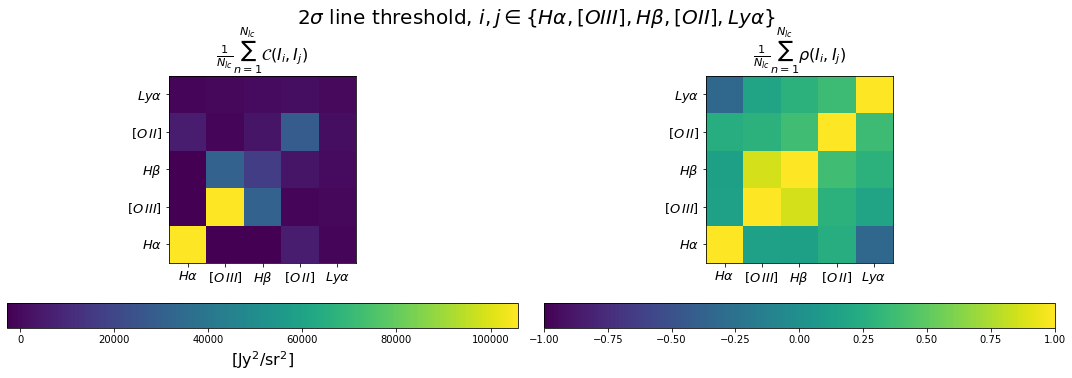

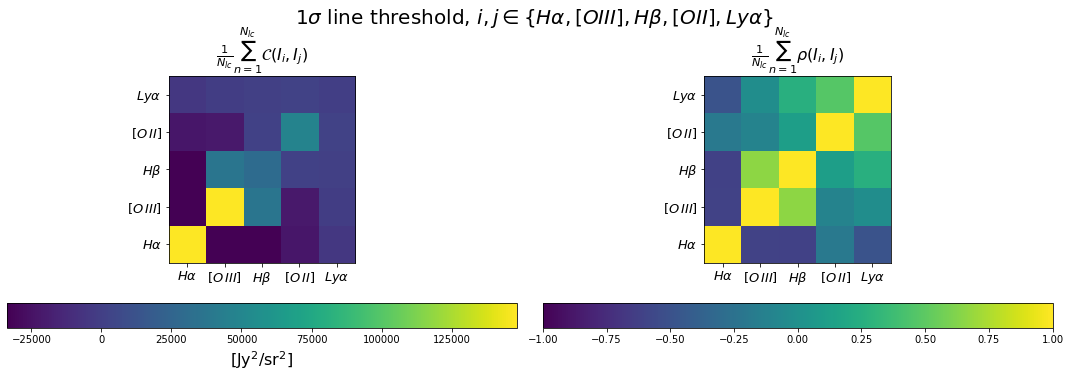

In [714]:
def plot_indiv_cov_corr_data_mats(covariance_mat, corr_mat, data_matrix):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(covariance_mat)
    plt.colorbar()
    plt.subplot(1,2,2)

    plt.figure()
    plt.imshow(corr_mat)
    plt.colorbar()
    plt.show()

    plt.figure()
    plt.title('data matrix')
    plt.imshow(data_matrix.transpose())
    plt.colorbar()
    plt.show()
       

def Ipred_targ_covariance(Ipred_targ_arr, line_name_array, nsigth=5, return_fig=True):
    
    list_of_covariance_mats = []
    list_of_corr_mats = []
    
#     list_of_covariance_mats = np.zeros((Ipred_targ_arr.shape[2], Ipred_targ_arr.shape[1], Ipred_targ_arr.shape[1]))
#     list_of_corr_mats = np.zeros((Ipred_targ_arr.shape[2], Ipred_targ_arr.shape[1], Ipred_targ_arr.shape[1]))
    
    

    for ilc in range(Ipred_targ_arr.shape[2]):


        data_matrix = np.zeros((Ipred_targ_arr.shape[0], Ipred_targ_arr.shape[1]))

        for n in range(Ipred_targ_arr.shape[0]):
            ravel_nus = []
            for line_idx in range(Ipred_targ_arr.shape[1]):
                ravel_nus.append(np.sum(Ipred_targ_arr[n, line_idx, ilc,:]))
            data_matrix[n,:] = ravel_nus


        covariance_mat = np.cov(data_matrix.transpose())
        corr_mat = np.corrcoef(data_matrix.transpose())

        if np.sum(np.abs(covariance_mat))>0.1:
#             plot_indiv_cov_corr_data_mats(covariance_mat, corr_mat, data_matrix)


            list_of_covariance_mats.append(covariance_mat)
            list_of_corr_mats.append(corr_mat)

                

    mean_covariance = np.nanmean(np.array(list_of_covariance_mats), axis=0)
    mean_corr = np.nanmean(np.array(list_of_corr_mats), axis=0)
    
    fig = plt.figure(figsize=(15, 5))
    plt.suptitle(str(nsigth)+'$\\sigma$ line threshold, $i,j\\in \\lbrace H\\alpha,[OIII],H\\beta,[OII],Ly\\alpha\\rbrace$', fontsize=20, y=1.02)
    plt.subplot(1,2,1)
    plt.title('$\\frac{1}{N_{lc}}\\sum_{n=1}^{N_{lc}}\\mathcal{C}(I_i,I_j)$', fontsize=16)
    
    plt.imshow(mean_covariance, vmin=np.percentile(mean_covariance, 15), vmax=np.percentile(mean_covariance, 95), origin='lower')
    cbar = plt.colorbar(orientation='horizontal')
    cbar.set_label('[Jy$^2$/sr$^2$]', fontsize=16)
    plt.xticks(np.arange(5), line_name_array, fontsize=13)
    plt.yticks(np.arange(5), line_name_array, fontsize=13)
    plt.subplot(1,2,2)
    plt.title('$\\frac{1}{N_{lc}}\\sum_{n=1}^{N_{lc}}\\rho(I_i,I_j)$', fontsize=16)
    plt.imshow(mean_corr, vmin=-1, vmax=1, origin='lower')
    plt.colorbar(orientation='horizontal')
    plt.xticks(np.arange(5), line_name_array, fontsize=13)
    plt.yticks(np.arange(5), line_name_array, fontsize=13)

    plt.tight_layout()
    plt.show()
    
    if return_fig:
        return fig, mean_covariance, mean_corr, list_of_covariance_mats, list_of_corr_mats
    else:
        return mean_covariance, mean_corr, list_of_covariance_mats, list_of_corr_mats
    
# print(ip_3sig_st)
# lo10 = Ipred_targ_covariance(ip_3sig_st[:10,:,:,:])
# lo30 = Ipred_targ_covariance(ip_3sig_st[:30,:,:,:])
f5, _, _, _, _  = Ipred_targ_covariance(ip_5sig_st, x.line_name_arr, nsigth=5)
f4, _, _, _, _  = Ipred_targ_covariance(ip_4sig_st, x.line_name_arr, nsigth=4)

f3, _, _, _, _  = Ipred_targ_covariance(ip_3sig_st, x.line_name_arr, nsigth=3)
f2, _, _, _, _  = Ipred_targ_covariance(ip_2sig_st, x.line_name_arr, nsigth=2)
f1, _, _, _, _  = Ipred_targ_covariance(ip_1sig_st, x.line_name_arr, nsigth=1)

f5.savefig('figures/mean_cov_corr_500lines_nsigth5_9_8_20.png', bbox_inches='tight')
f4.savefig('figures/mean_cov_corr_500lines_nsigth4_9_8_20.png', bbox_inches='tight')

f3.savefig('figures/mean_cov_corr_500lines_nsigth3_9_8_20.png', bbox_inches='tight')
f2.savefig('figures/mean_cov_corr_500lines_nsigth2_9_8_20.png', bbox_inches='tight')
f1.savefig('figures/mean_cov_corr_500lines_nsigth1_9_8_20.png', bbox_inches='tight')

In [908]:
print(ip_5sig_st.shape)
print(np.array(f_arr3sig2).shape)

(20, 5, 500, 96)
(20, 50, 96)


sum_cov.shape[0]: 96
select idxs is  [17 18 28 29 40 41 42 51 52]
sum_cov.shape[0]: 96
select idxs is  [ 6 17 18 29 30 31 41]
sum_cov.shape[0]: 96
select idxs is  [ 4  5 15 16 17 27 28 29 39 40]
sum_cov.shape[0]: 96
select idxs is  [ 4  5  6 16 17 18 28 29]


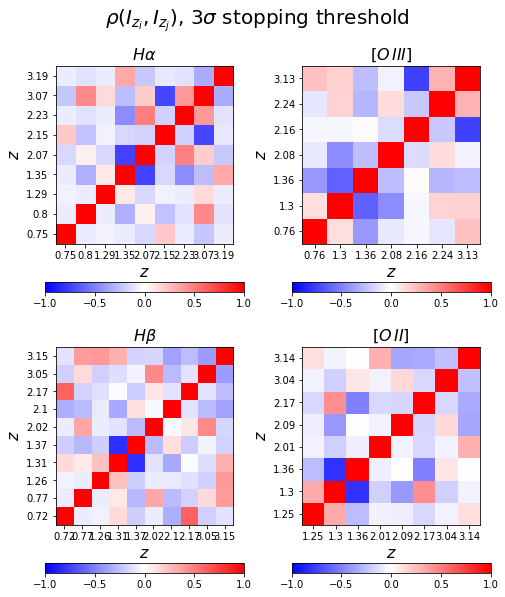

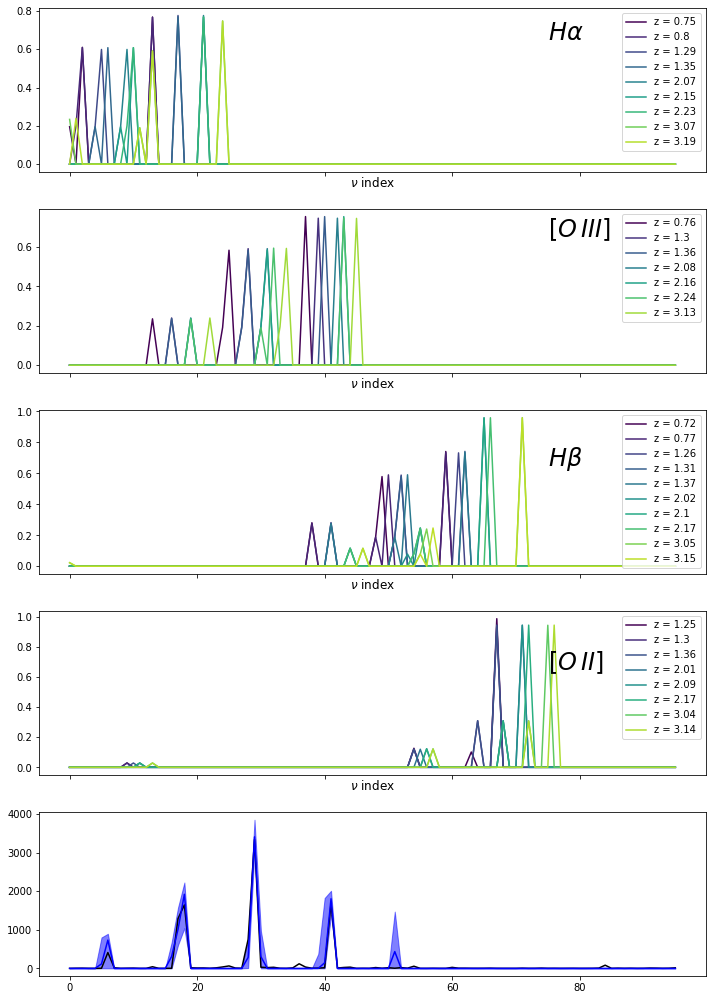

sum_cov.shape[0]: 96
select idxs is  [42 43 52]
sum_cov.shape[0]: 96
select idxs is  [30 31 42]
sum_cov.shape[0]: 96
select idxs is  [29 30 40 41]
sum_cov.shape[0]: 96
select idxs is  [18 19 29 30]


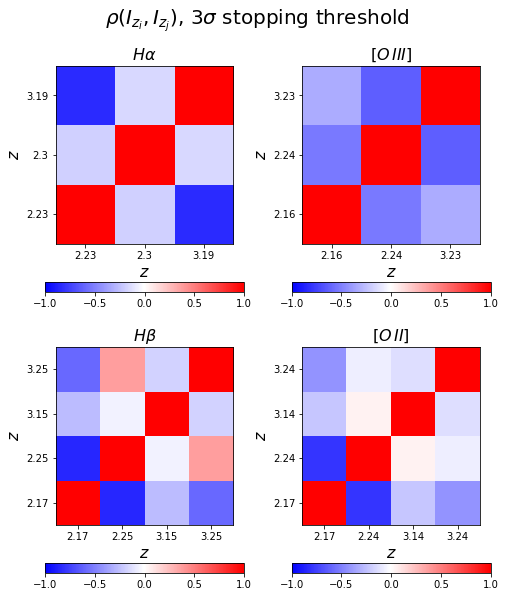

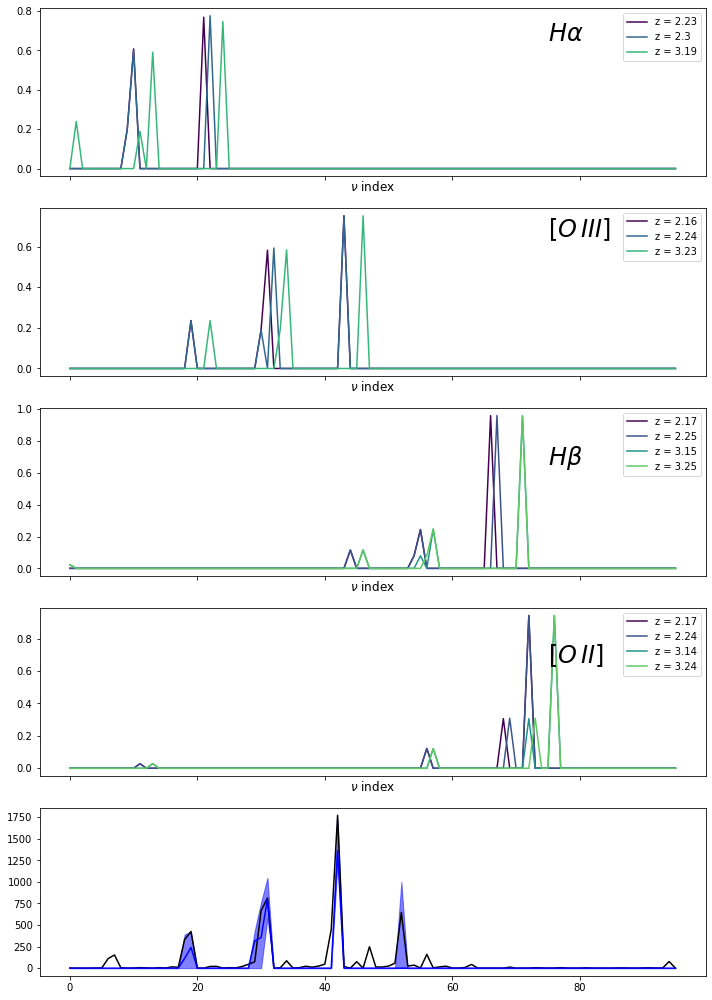

sum_cov.shape[0]: 96
select idxs is  None
sum_cov.shape[0]: 96
select idxs is  None
sum_cov.shape[0]: 96
select idxs is  [7 8]


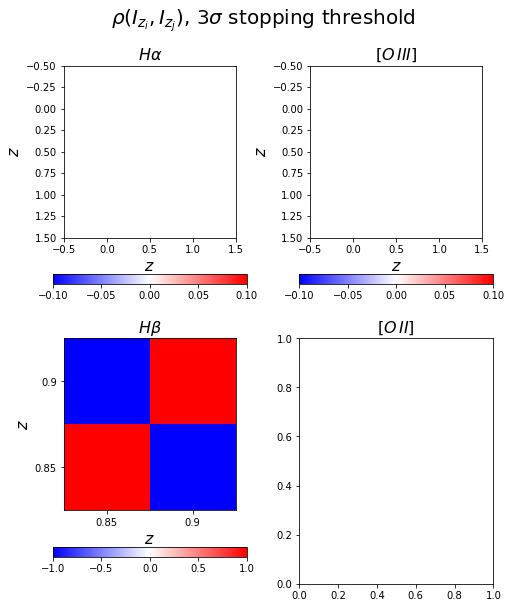

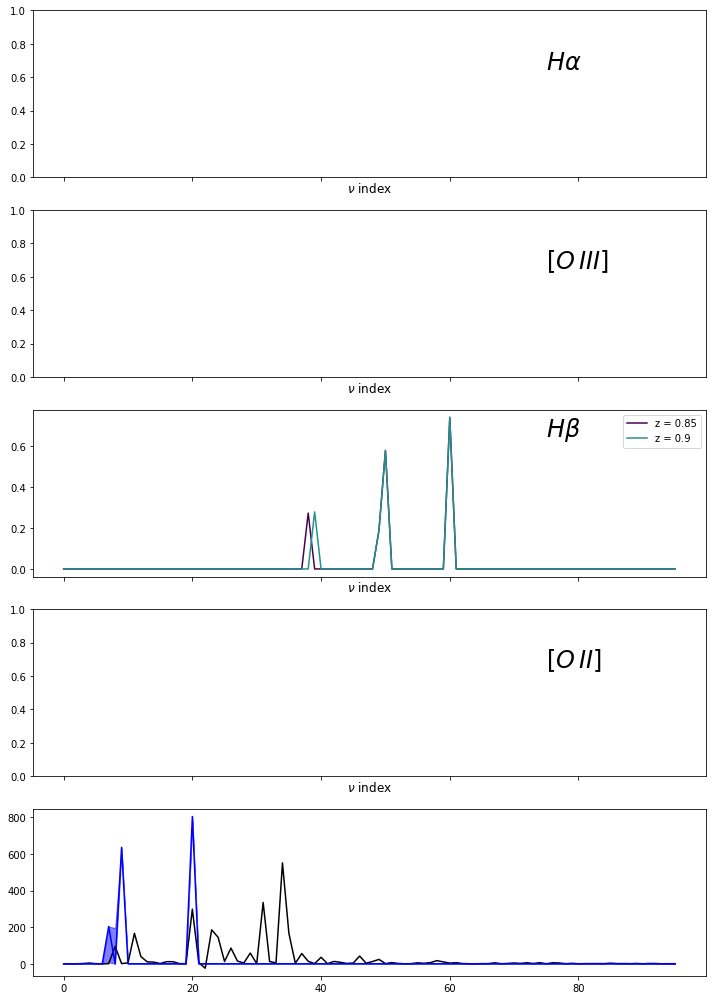

sum_cov.shape[0]: 96
select idxs is  None
sum_cov.shape[0]: 96
select idxs is  [56 70]
sum_cov.shape[0]: 96
select idxs is  [55 66 67]
sum_cov.shape[0]: 96
select idxs is  [45 46 55 70]


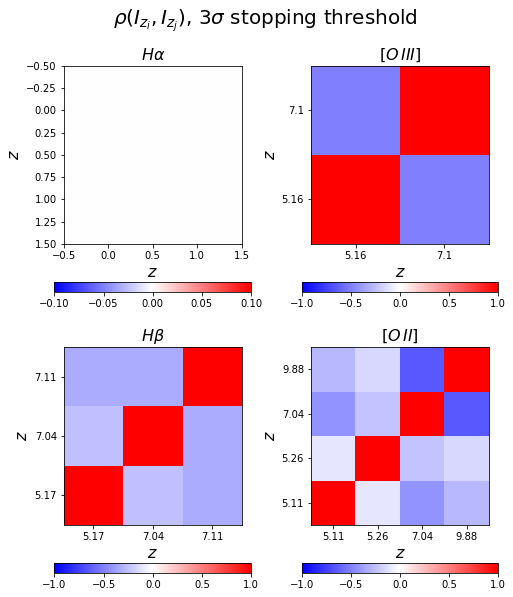

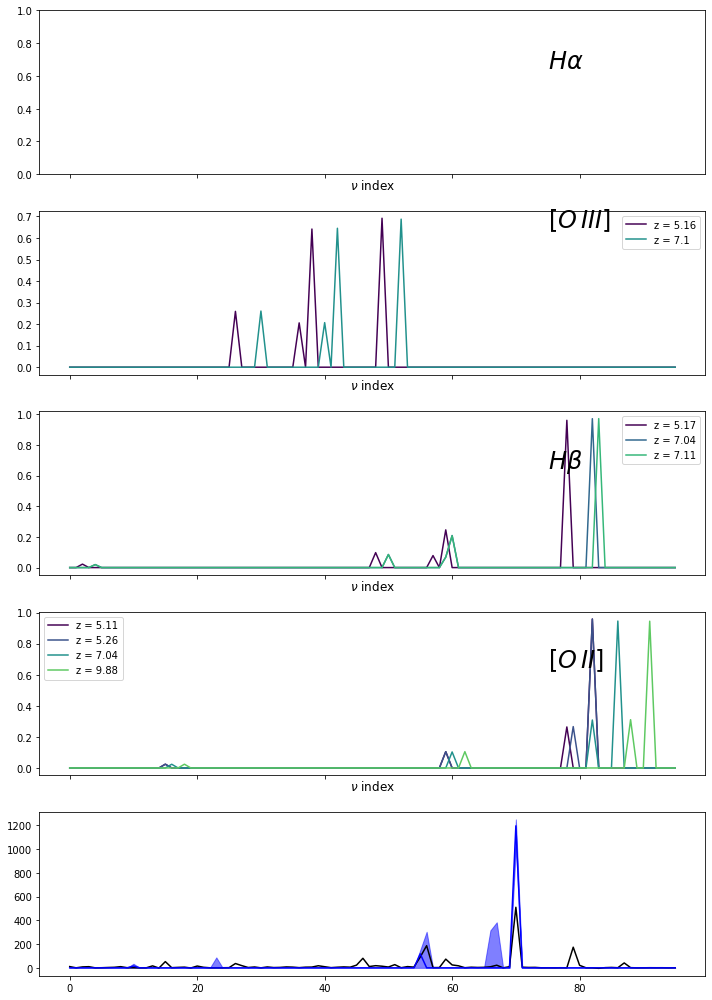

sum_cov.shape[0]: 96
select idxs is  [37 48]
sum_cov.shape[0]: 96
select idxs is  [25 26 37]
sum_cov.shape[0]: 96
select idxs is  [24 25 35 36]
sum_cov.shape[0]: 96
select idxs is  [13 14 24 25]


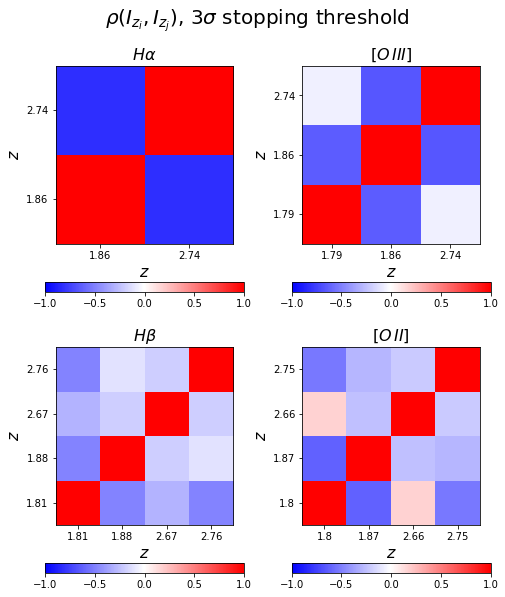

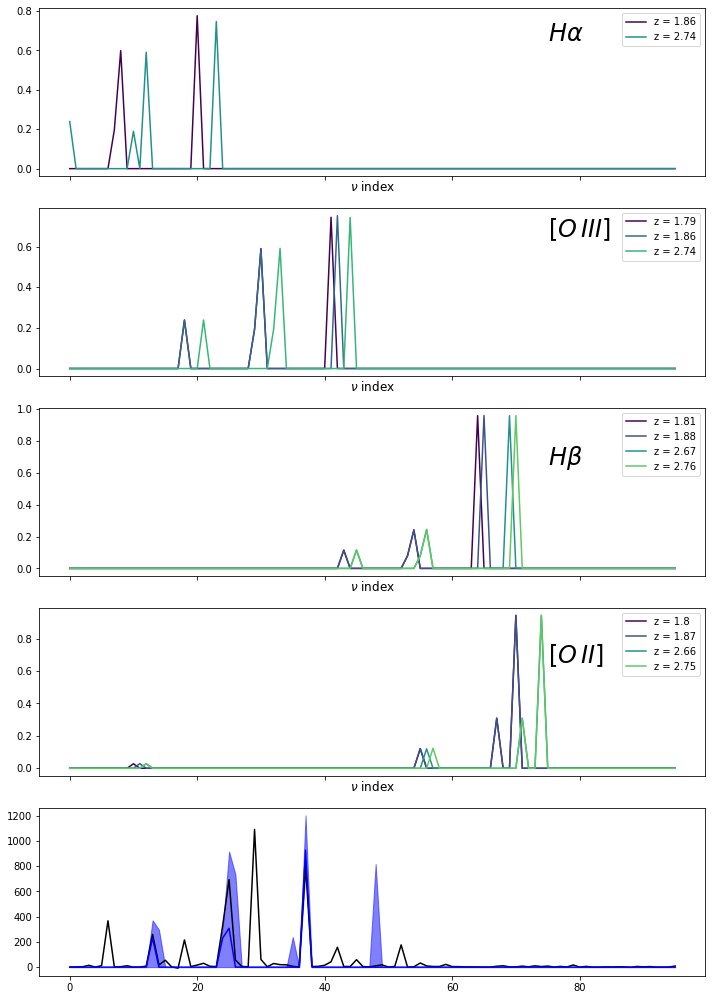

In [911]:
fig3s = []
for n in range(5):
    f3_red, f3_lines, _ = x.Ipred_targ_redshift_covariance(ip_3sig_st2[:,:,n,:], x.line_name_arr, nsigth=3, ilc_idx=n, f_arr_pred=np.array(f_arr3sig2)[:,n,:])

#     f3_red, f3_lines, _ = x.Ipred_targ_redshift_covariance(ip_3sig_st[:,:,n,:], x.line_name_arr, nsigth=3, ilc_idx=n)
#     if f3_red is not None:
#         fig3s.append(f3_red)
#     if f3_red is not None:
#         f3_lines.suptitle('Lightcone Index ='+str(n), fontsize=20, y=1.05)
#         f3_red.suptitle('$\\rho(I_{z_i},I_{z_j})$, 3$\\sigma$ stopping threshold \n Lightcone Index ='+str(n), fontsize=20, y=1.05)

#         f3_red.savefig('figures/500lines/3sigth_9_9_20/zoom_redshift_cov_idx'+str(n)+'_3sigth_9_9.png', bbox_inches='tight')
#         f3_lines.savefig('figures/500lines/3sigth_9_9_20/line_templates_and_redshifts_idx'+str(n)+'_3sigth_9_9.png', bbox_inches='tight')
        
# print(len(fig3s))


sum_cov.shape[0]: 96
select idxs is  [18 28 29 40 41]
sum_cov.shape[0]: 96
select idxs is  [ 6  7 17 18 29 30]
sum_cov.shape[0]: 96
select idxs is  [ 5  6 15 16 17 27 28 29]
sum_cov.shape[0]: 96
select idxs is  [ 4  5  6 16 17 18]


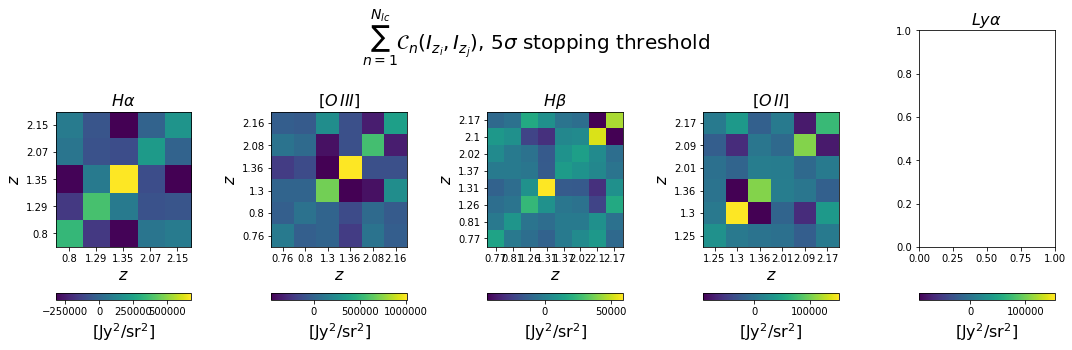

In [537]:
f5_red,_ = x.Ipred_targ_redshift_covariance(ip_5sig_st[:,:,:1,:], x.line_name_arr, nsigth=5)
# f4_red,_ = x.Ipred_targ_redshift_covariance(ip_4sig_st[:,:,:2,:], x.line_name_arr, nsigth=4)

# f3_red,_ = x.Ipred_targ_redshift_covariance(ip_3sig_st[:,:,:2,:], x.line_name_arr, nsigth=3)
# f2_red,_ = x.Ipred_targ_redshift_covariance(ip_2sig_st[:,:,:2,:], x.line_name_arr, nsigth=2)
# f1_red,_ = x.Ipred_targ_redshift_covariance(ip_1sig_st[:,:,:2,:], x.line_name_arr, nsigth=1)

# f5_red.savefig('figures/sum_redshift_cov_500lines_nsigth5_9_8_20.png', bbox_inches='tight')
# f4_red.savefig('figures/sum_redshift_cov_500lines_nsigth4_9_8_20.png', bbox_inches='tight')
# f3_red.savefig('figures/sum_redshift_cov_500lines_nsigth3_9_8_20.png', bbox_inches='tight')
# f2_red.savefig('figures/sum_redshift_cov_500lines_nsigth2_9_8_20.png', bbox_inches='tight')
# f1_red.savefig('figures/sum_redshift_cov_500lines_nsigth1_9_8_20.png', bbox_inches='tight')

In [397]:
ip_4sig_st, f_arr, iter_ct_st, _ = x.sim_noise(nsims=20, N_lc=500, amp_nsigma=4., iter_max=10, show_iter_plots=False, stochastic=True, fast_lines=False)


Ipred targ has shape  (20, 5, 500, 96)
specific lines has shape (500, 96)
i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
i =  10
i =  11
i =  12
i =  13
i =  14
i =  15
i =  16
i =  17
i =  18
i =  19


In [227]:
ip_1sig_st, f_arr, iter_ct_st = x.sim_noise(nsims=20, N_lc=500, amp_nsigma=1., iter_max=10, show_iter_plots=False, stochastic=True, fast_lines=False)


Ipred targ has shape  (20, 5, 500, 96)
time elapsed for slow version is  0.6001591682434082
N_pred has shape  (500, 385)
Ipred targ has shape (5, 500, 96)
i =  0
time elapsed for slow version is  0.6316590309143066
N_pred has shape  (500, 385)
Ipred targ has shape (5, 500, 96)
i =  1
time elapsed for slow version is  0.6541478633880615
N_pred has shape  (500, 385)
Ipred targ has shape (5, 500, 96)
i =  2
time elapsed for slow version is  0.8994240760803223
N_pred has shape  (500, 385)
Ipred targ has shape (5, 500, 96)
i =  3
time elapsed for slow version is  0.7540168762207031
N_pred has shape  (500, 385)
Ipred targ has shape (5, 500, 96)
i =  4
time elapsed for slow version is  0.5801129341125488
N_pred has shape  (500, 385)
Ipred targ has shape (5, 500, 96)
i =  5
time elapsed for slow version is  0.6578760147094727
N_pred has shape  (500, 385)
Ipred targ has shape (5, 500, 96)
i =  6
time elapsed for slow version is  1.1898367404937744
N_pred has shape  (500, 385)
Ipred targ has sha

In [228]:
ip_2sig_st, f_arr, iter_ct_st = x.sim_noise(nsims=20, N_lc=500, amp_nsigma=2., iter_max=10, show_iter_plots=False, stochastic=True, fast_lines=False)


Ipred targ has shape  (20, 5, 500, 96)
time elapsed for slow version is  0.5352871417999268
N_pred has shape  (500, 385)
Ipred targ has shape (5, 500, 96)
i =  0
time elapsed for slow version is  0.42254090309143066
N_pred has shape  (500, 385)
Ipred targ has shape (5, 500, 96)
i =  1
time elapsed for slow version is  0.4191408157348633
N_pred has shape  (500, 385)
Ipred targ has shape (5, 500, 96)
i =  2
time elapsed for slow version is  0.4510037899017334
N_pred has shape  (500, 385)
Ipred targ has shape (5, 500, 96)
i =  3
time elapsed for slow version is  0.46014904975891113
N_pred has shape  (500, 385)
Ipred targ has shape (5, 500, 96)
i =  4
time elapsed for slow version is  0.5680949687957764
N_pred has shape  (500, 385)
Ipred targ has shape (5, 500, 96)
i =  5
time elapsed for slow version is  0.5438222885131836
N_pred has shape  (500, 385)
Ipred targ has shape (5, 500, 96)
i =  6
time elapsed for slow version is  0.42658090591430664
N_pred has shape  (500, 385)
Ipred targ has 

In [907]:
# ip_3sig_st, f_arr, iter_ct_st = x.sim_noise(nsims=20, N_lc=500, amp_nsigma=3., iter_max=10, show_iter_plots=False, stochastic=True, fast_lines=False)
ip_3sig_st2, f_arr3sig2, iter_ct_st3sig2, _ = x.sim_noise(nsims=20, N_lc=50, amp_nsigma=3., iter_max=10, show_iter_plots=False, stochastic=True, fast_lines=False)


Ipred targ has shape  (20, 5, 50, 96)
specific lines has shape (50, 96)
f_arr_lines has shape  (50, 96)
f_arr_lines has shape  (50, 96)
f_arr_lines has shape  (50, 96)
f_arr_lines has shape  (50, 96)
f_arr_lines has shape  (50, 96)
f_arr_lines has shape  (50, 96)
f_arr_lines has shape  (50, 96)
f_arr_lines has shape  (50, 96)
f_arr_lines has shape  (50, 96)
f_arr_lines has shape  (50, 96)
f_arr_lines has shape  (50, 96)
f_arr_lines has shape  (50, 96)
f_arr_lines has shape  (50, 96)
f_arr_lines has shape  (50, 96)
f_arr_lines has shape  (50, 96)
f_arr_lines has shape  (50, 96)
f_arr_lines has shape  (50, 96)
f_arr_lines has shape  (50, 96)
f_arr_lines has shape  (50, 96)
f_arr_lines has shape  (50, 96)


In [230]:
ip_5sig_st, f_arr, iter_ct_st = x.sim_noise(nsims=20, N_lc=500, amp_nsigma=5., iter_max=10, show_iter_plots=False, stochastic=True, fast_lines=False)


Ipred targ has shape  (20, 5, 500, 96)
time elapsed for slow version is  0.2200028896331787
N_pred has shape  (500, 385)
Ipred targ has shape (5, 500, 96)
i =  0
time elapsed for slow version is  0.11100006103515625
N_pred has shape  (500, 385)
Ipred targ has shape (5, 500, 96)
i =  1
time elapsed for slow version is  0.10748910903930664
N_pred has shape  (500, 385)
Ipred targ has shape (5, 500, 96)
i =  2
time elapsed for slow version is  0.10219407081604004
N_pred has shape  (500, 385)
Ipred targ has shape (5, 500, 96)
i =  3
time elapsed for slow version is  0.13772892951965332
N_pred has shape  (500, 385)
Ipred targ has shape (5, 500, 96)
i =  4
time elapsed for slow version is  0.12437987327575684
N_pred has shape  (500, 385)
Ipred targ has shape (5, 500, 96)
i =  5
time elapsed for slow version is  0.14671111106872559
N_pred has shape  (500, 385)
Ipred targ has shape (5, 500, 96)
i =  6
time elapsed for slow version is  0.1421031951904297
N_pred has shape  (500, 385)
Ipred targ h

In [203]:
ip_3sig, f_arr, iter_ct_no_stoch = x.sim_noise(nsims=10, N_lc=50, amp_nsigma=3., iter_max=10, show_iter_plots=False, stochastic=False, fast_lines=False)
# ip_1sig, f_arr, iter_ct_no_stoch = x.sim_noise(nsims=10, N_lc=50, amp_nsigma=1., iter_max=10, show_iter_plots=False, stochastic=False, fast_lines=False)


Ipred targ has shape  (10, 5, 50, 96)
time elapsed for slow version is  0.008475065231323242
N_pred has shape  (50, 385)
Ipred targ has shape (5, 50, 96)
time elapsed for slow version is  0.006281375885009766
N_pred has shape  (50, 385)
Ipred targ has shape (5, 50, 96)
time elapsed for slow version is  0.010877132415771484
N_pred has shape  (50, 385)
Ipred targ has shape (5, 50, 96)
time elapsed for slow version is  0.004801034927368164
N_pred has shape  (50, 385)
Ipred targ has shape (5, 50, 96)
time elapsed for slow version is  0.005290985107421875
N_pred has shape  (50, 385)
Ipred targ has shape (5, 50, 96)
time elapsed for slow version is  0.014059066772460938
N_pred has shape  (50, 385)
Ipred targ has shape (5, 50, 96)
time elapsed for slow version is  0.008779048919677734
N_pred has shape  (50, 385)
Ipred targ has shape (5, 50, 96)
time elapsed for slow version is  0.006299734115600586
N_pred has shape  (50, 385)
Ipred targ has shape (5, 50, 96)
time elapsed for slow version is  

data matrix has shape  (10, 5)
(5, 5)
2885078.9643968586
2885078.9643968586


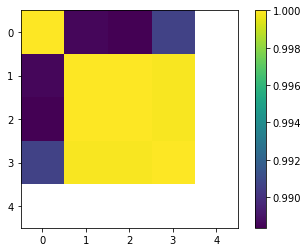

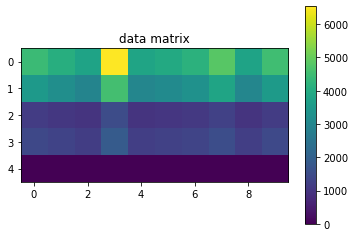

data matrix has shape  (10, 5)
(5, 5)
2097916.245548566
2097916.245548566


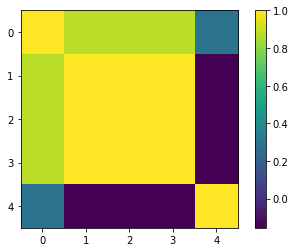

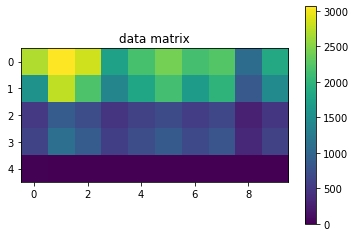

data matrix has shape  (10, 5)
(5, 5)
1569663.0179222424
1569663.0179222424


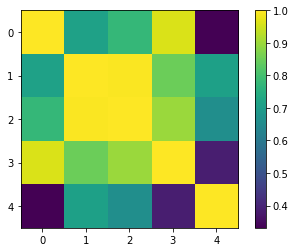

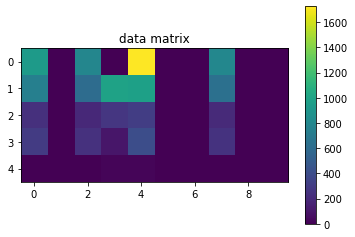

data matrix has shape  (10, 5)
(5, 5)
1381382.8928976976
1381382.8928976976


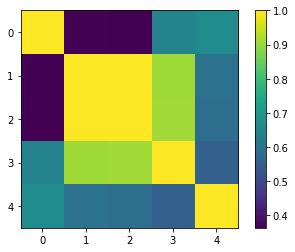

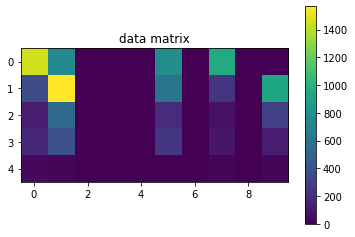

data matrix has shape  (10, 5)
(5, 5)
2181353.7384726917
2181353.7384726917


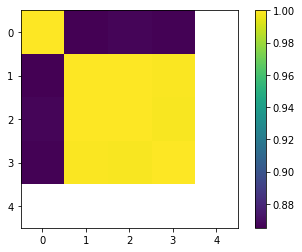

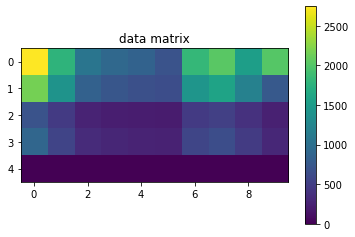

data matrix has shape  (10, 5)
(5, 5)
2925229.912378548
2925229.912378548


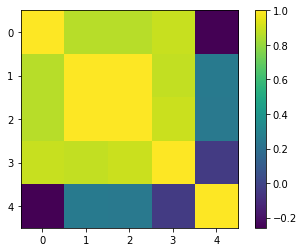

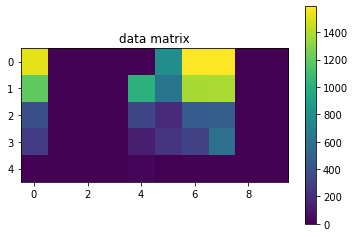

data matrix has shape  (10, 5)
(5, 5)
603443.7542891463
603443.7542891463


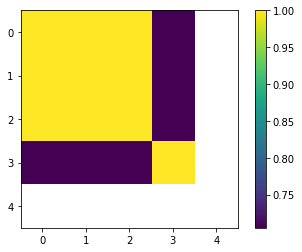

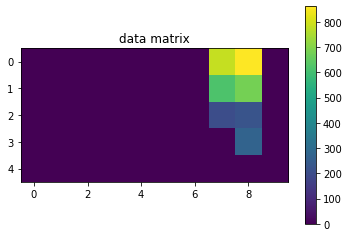

data matrix has shape  (10, 5)
(5, 5)
0.0
nope
data matrix has shape  (10, 5)
(5, 5)
2201143.8364867773
2201143.8364867773


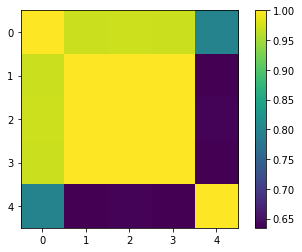

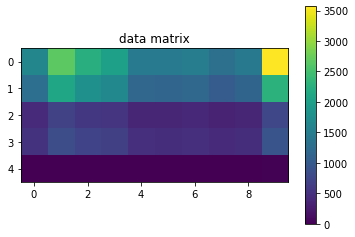

data matrix has shape  (10, 5)
(5, 5)
1388502.4572956853
1388502.4572956853


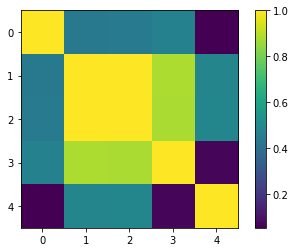

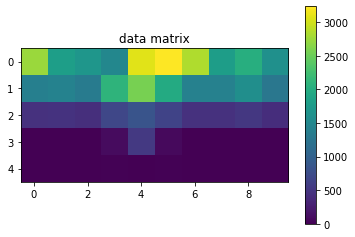

data matrix has shape  (10, 5)
(5, 5)
693958.2863756361
693958.2863756361


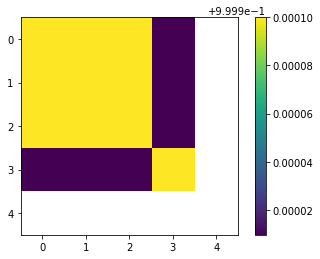

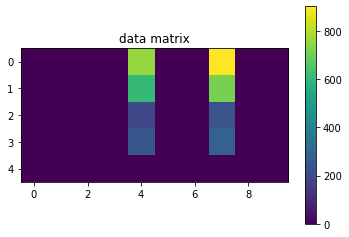

data matrix has shape  (10, 5)
(5, 5)
1274785.7043049945
1274785.7043049945


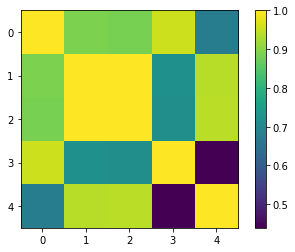

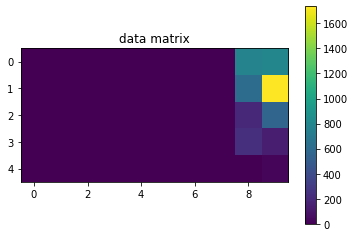

data matrix has shape  (10, 5)
(5, 5)
1251085.5416808233
1251085.5416808233


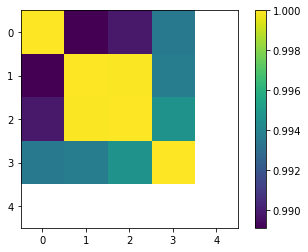

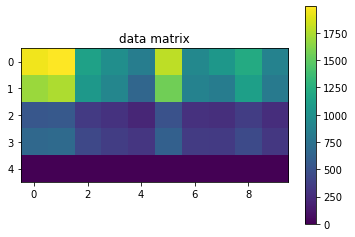

data matrix has shape  (10, 5)
(5, 5)
637197.6951235883
637197.6951235883


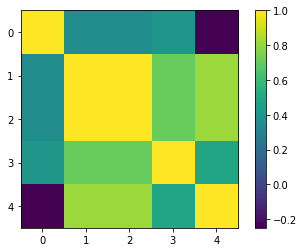

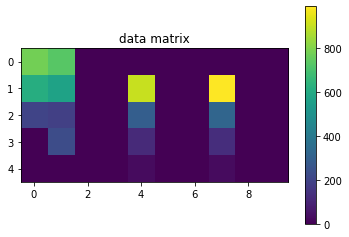

data matrix has shape  (10, 5)
(5, 5)
1186472.6899735234
1186472.6899735234


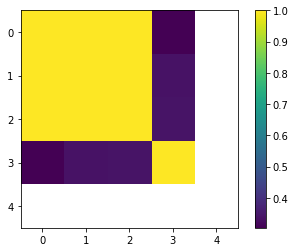

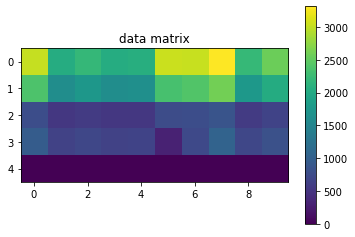

data matrix has shape  (10, 5)
(5, 5)
1885102.1269299074
1885102.1269299074


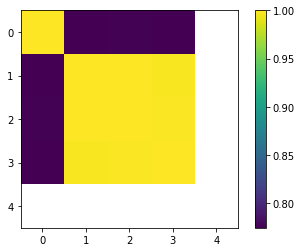

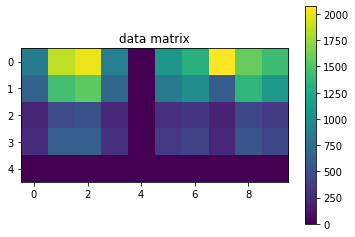

data matrix has shape  (10, 5)
(5, 5)
710419.0745880599
710419.0745880599


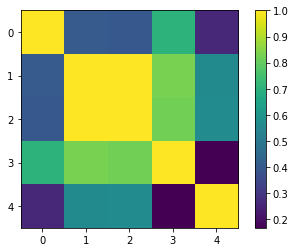

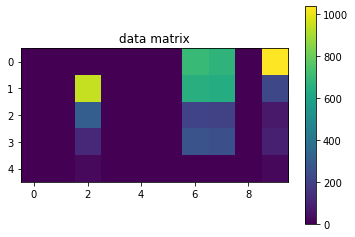

data matrix has shape  (10, 5)
(5, 5)
3848076.791596333
3848076.791596333


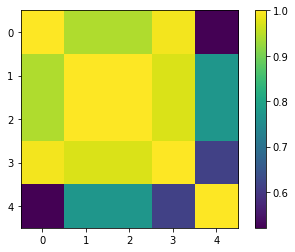

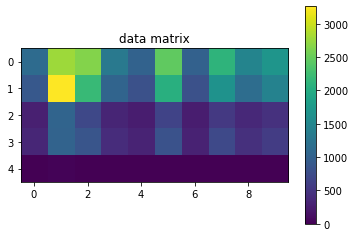

data matrix has shape  (10, 5)
(5, 5)
1279904.592682481
1279904.592682481


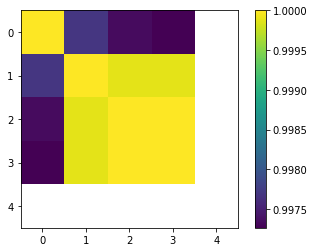

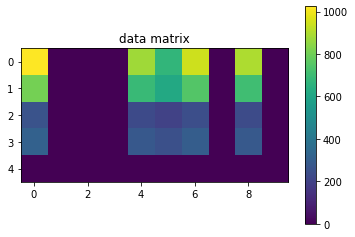

data matrix has shape  (10, 5)
(5, 5)
2669572.714737444
2669572.714737444


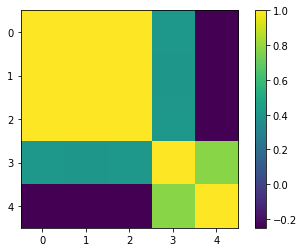

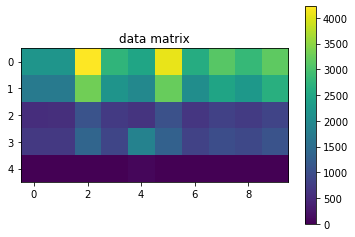

data matrix has shape  (10, 5)
(5, 5)
2629845.4132720595
2629845.4132720595


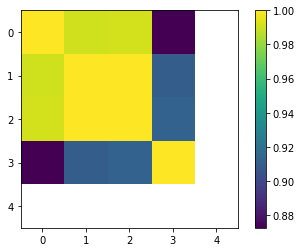

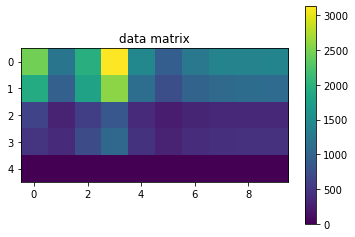

data matrix has shape  (10, 5)
(5, 5)
1369999.307884025
1369999.307884025


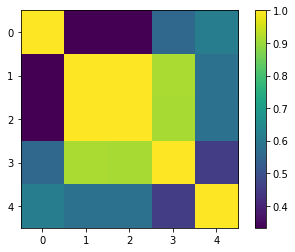

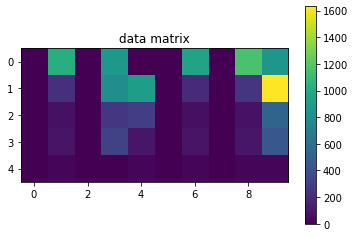

data matrix has shape  (10, 5)
(5, 5)
1067188.5476913159
1067188.5476913159


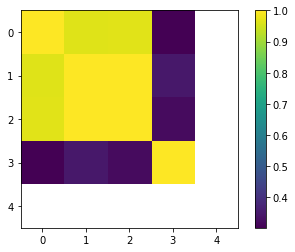

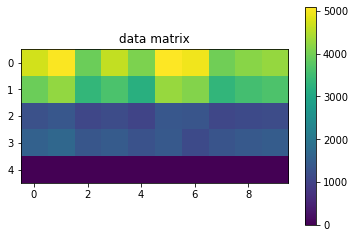

data matrix has shape  (10, 5)
(5, 5)
1492551.3950937346
1492551.3950937346


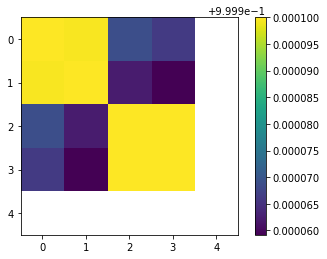

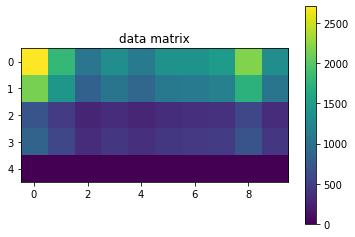

data matrix has shape  (10, 5)
(5, 5)
761464.1151696696
761464.1151696696


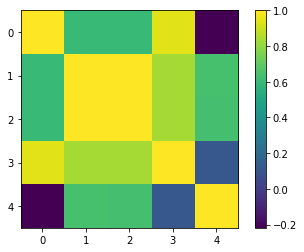

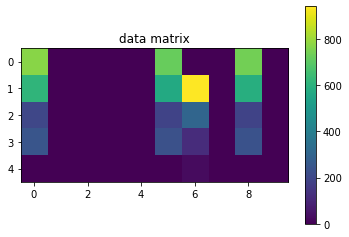

data matrix has shape  (10, 5)
(5, 5)
5732473.729612282
5732473.729612282


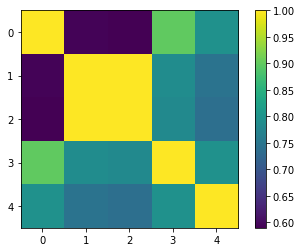

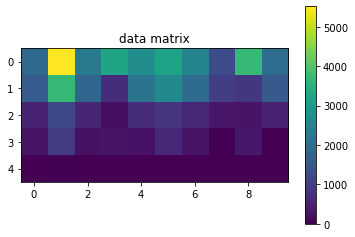

data matrix has shape  (10, 5)
(5, 5)
1119210.2186961924
1119210.2186961924


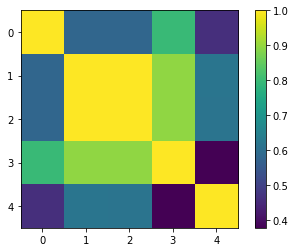

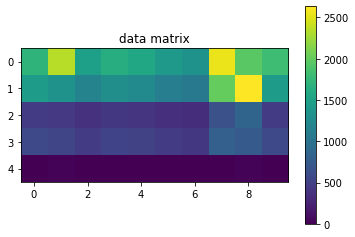

data matrix has shape  (10, 5)
(5, 5)
1934093.85373832
1934093.85373832


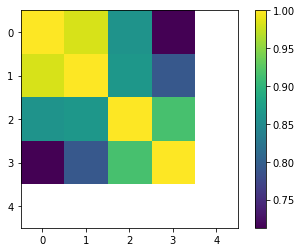

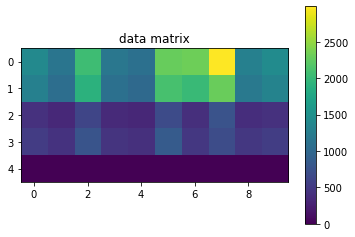

data matrix has shape  (10, 5)
(5, 5)
286226.78894265235
286226.78894265235


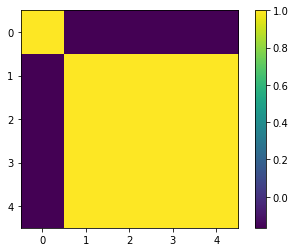

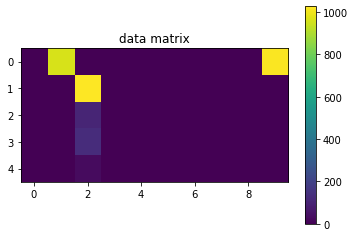

data matrix has shape  (10, 5)
(5, 5)
805358.2422520282
805358.2422520282


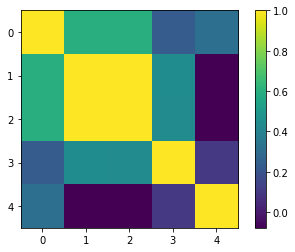

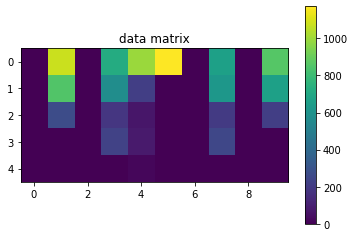

data matrix has shape  (10, 5)
(5, 5)
4660983.645715322
4660983.645715322


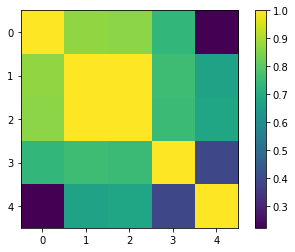

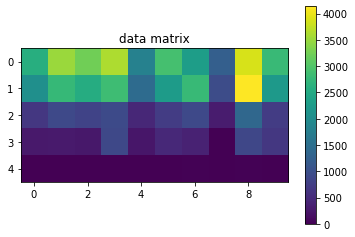

data matrix has shape  (10, 5)
(5, 5)
1682732.0801851694
1682732.0801851694


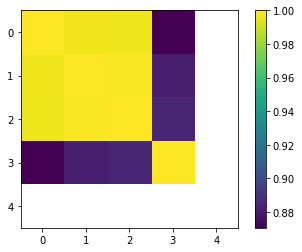

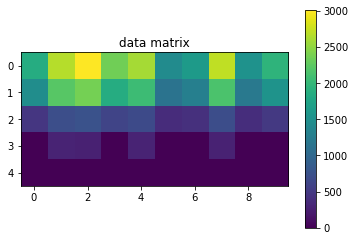

data matrix has shape  (10, 5)
(5, 5)
1486805.6098748823
1486805.6098748823


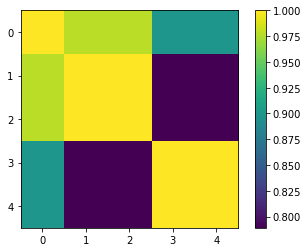

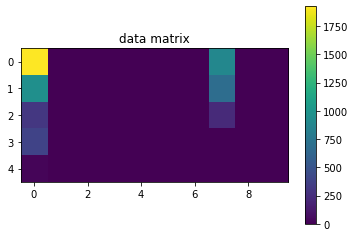

data matrix has shape  (10, 5)
(5, 5)
975162.1273397827
975162.1273397827


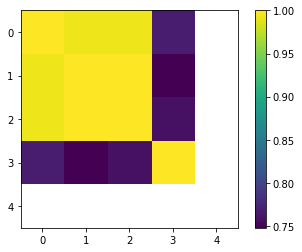

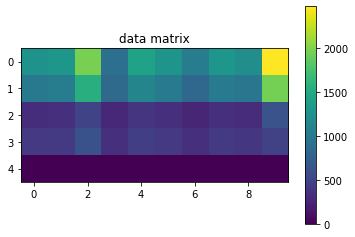

data matrix has shape  (10, 5)
(5, 5)
2786623.3181527634
2786623.3181527634


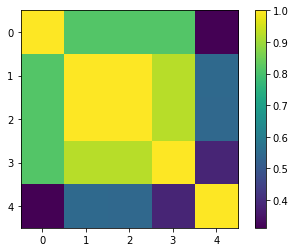

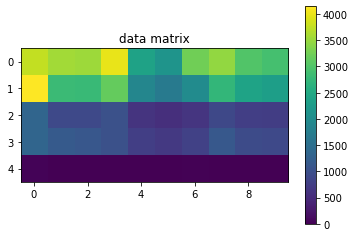

data matrix has shape  (10, 5)
(5, 5)
2066377.8679599692
2066377.8679599692


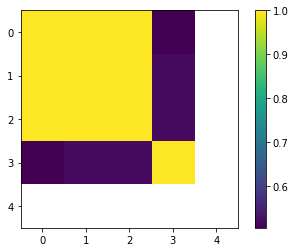

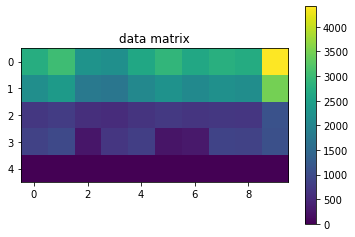

data matrix has shape  (10, 5)
(5, 5)
573626.3708771148
573626.3708771148


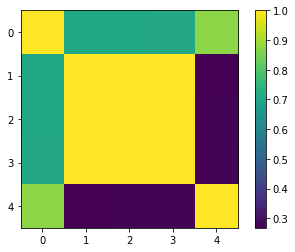

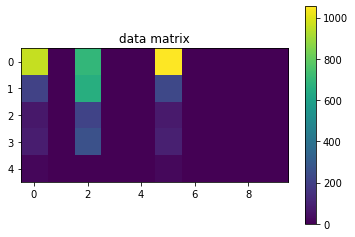

data matrix has shape  (10, 5)
(5, 5)
0.0
nope
data matrix has shape  (10, 5)
(5, 5)
1703181.486553881
1703181.486553881


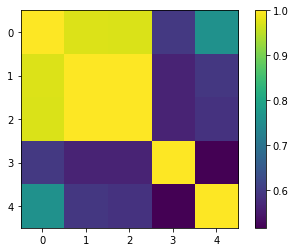

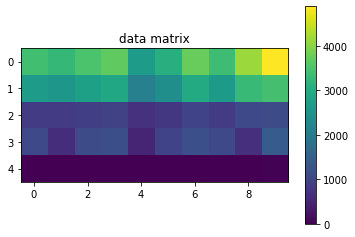

data matrix has shape  (10, 5)
(5, 5)
690738.3527169821
690738.3527169821


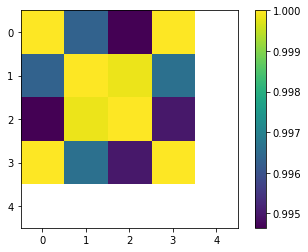

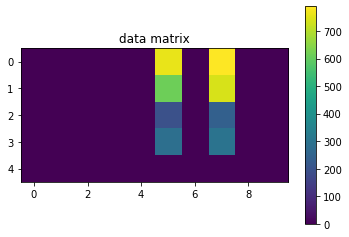

data matrix has shape  (10, 5)
(5, 5)
658549.3377185962
658549.3377185962


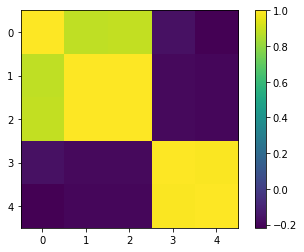

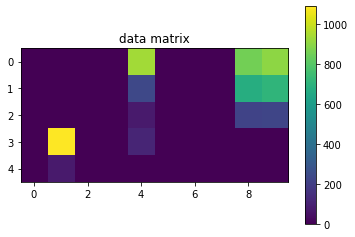

data matrix has shape  (10, 5)
(5, 5)
685763.5677890738
685763.5677890738


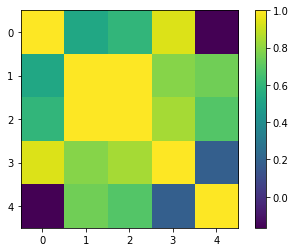

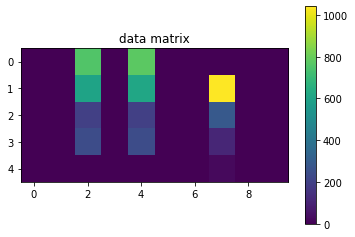

data matrix has shape  (10, 5)
(5, 5)
1967046.1793273096
1967046.1793273096


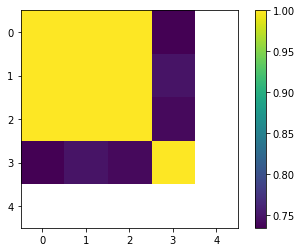

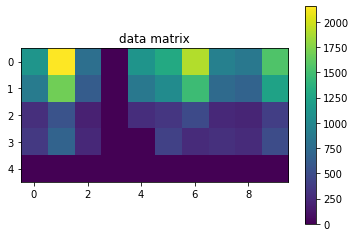

data matrix has shape  (10, 5)
(5, 5)
636737.943256841
636737.943256841


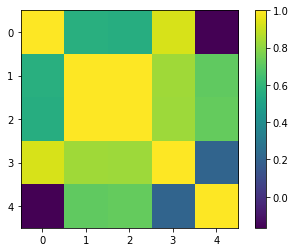

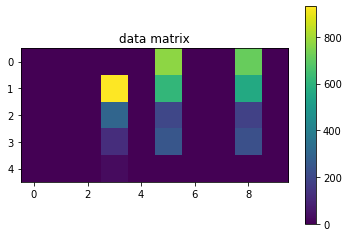

data matrix has shape  (10, 5)
(5, 5)
960348.2267974645
960348.2267974645


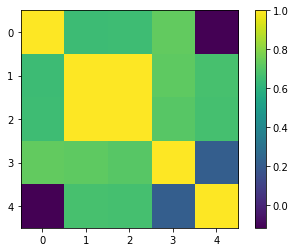

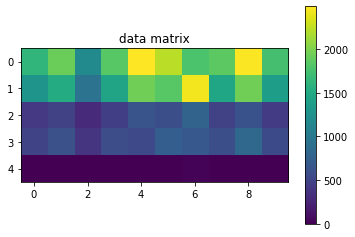

data matrix has shape  (10, 5)
(5, 5)
427160.48859229166
427160.48859229166


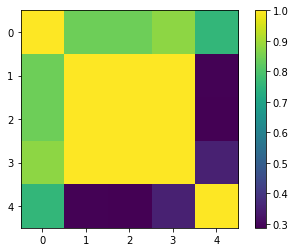

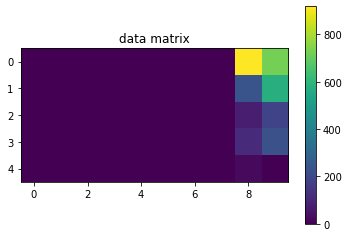

data matrix has shape  (10, 5)
(5, 5)
3816812.0772158466
3816812.0772158466


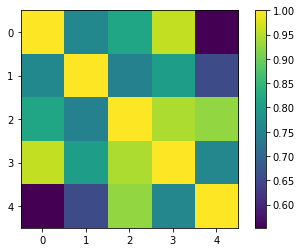

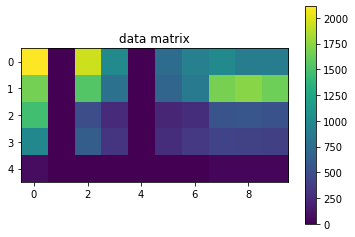

data matrix has shape  (10, 5)
(5, 5)
3204890.556504991
3204890.556504991


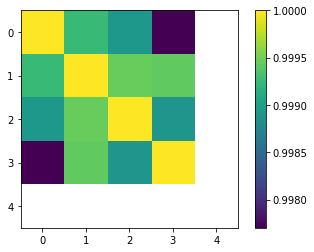

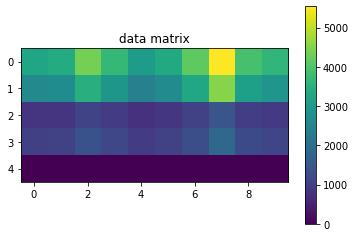

data matrix has shape  (10, 5)
(5, 5)
1951395.9866036372
1951395.9866036372


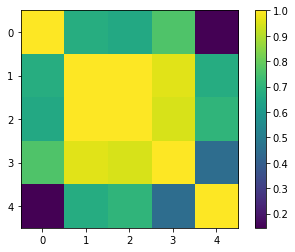

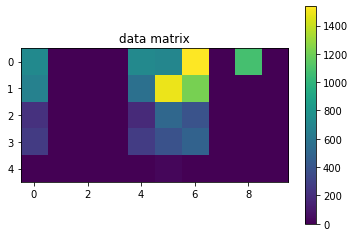

data matrix has shape  (10, 5)
(5, 5)
231625.81667984536
231625.81667984536


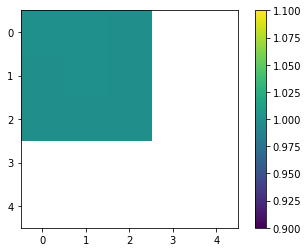

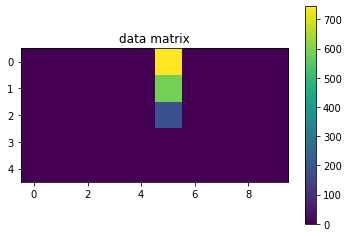

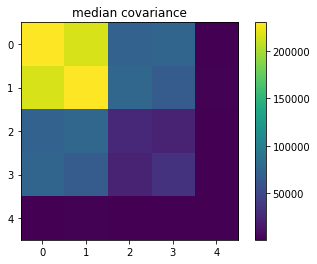

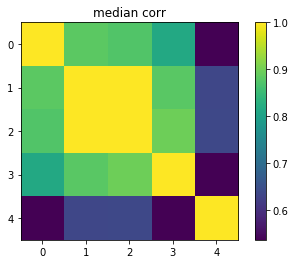

In [204]:
lo = Ipred_targ_covariance(ip_3sig)

In [588]:
ip_3sig_st, f_arr, iter_ct_no_stoch = x.sim_noise(nsims=10, N_lc=2500, amp_nsigma=3., iter_max=10, show_iter_plots=False, stochastic=True, fast_lines=False)
ip_1sig_st, f_arr, iter_ct_no_stoch = x.sim_noise(nsims=10, N_lc=2500, amp_nsigma=1., iter_max=10, show_iter_plots=False, stochastic=True, fast_lines=False)


Ipred targ has shape  (10, 5, 2500, 96)
time elapsed for slow version is  3.089766263961792
i =  0
time elapsed for slow version is  2.232161045074463
i =  1
time elapsed for slow version is  2.247995138168335
i =  2
time elapsed for slow version is  3.9247312545776367
i =  3
time elapsed for slow version is  2.1625638008117676
i =  4
time elapsed for slow version is  2.141235113143921
i =  5
time elapsed for slow version is  2.1294121742248535
i =  6
time elapsed for slow version is  2.90408992767334
i =  7
time elapsed for slow version is  2.2022147178649902
i =  8
time elapsed for slow version is  2.4440109729766846
i =  9


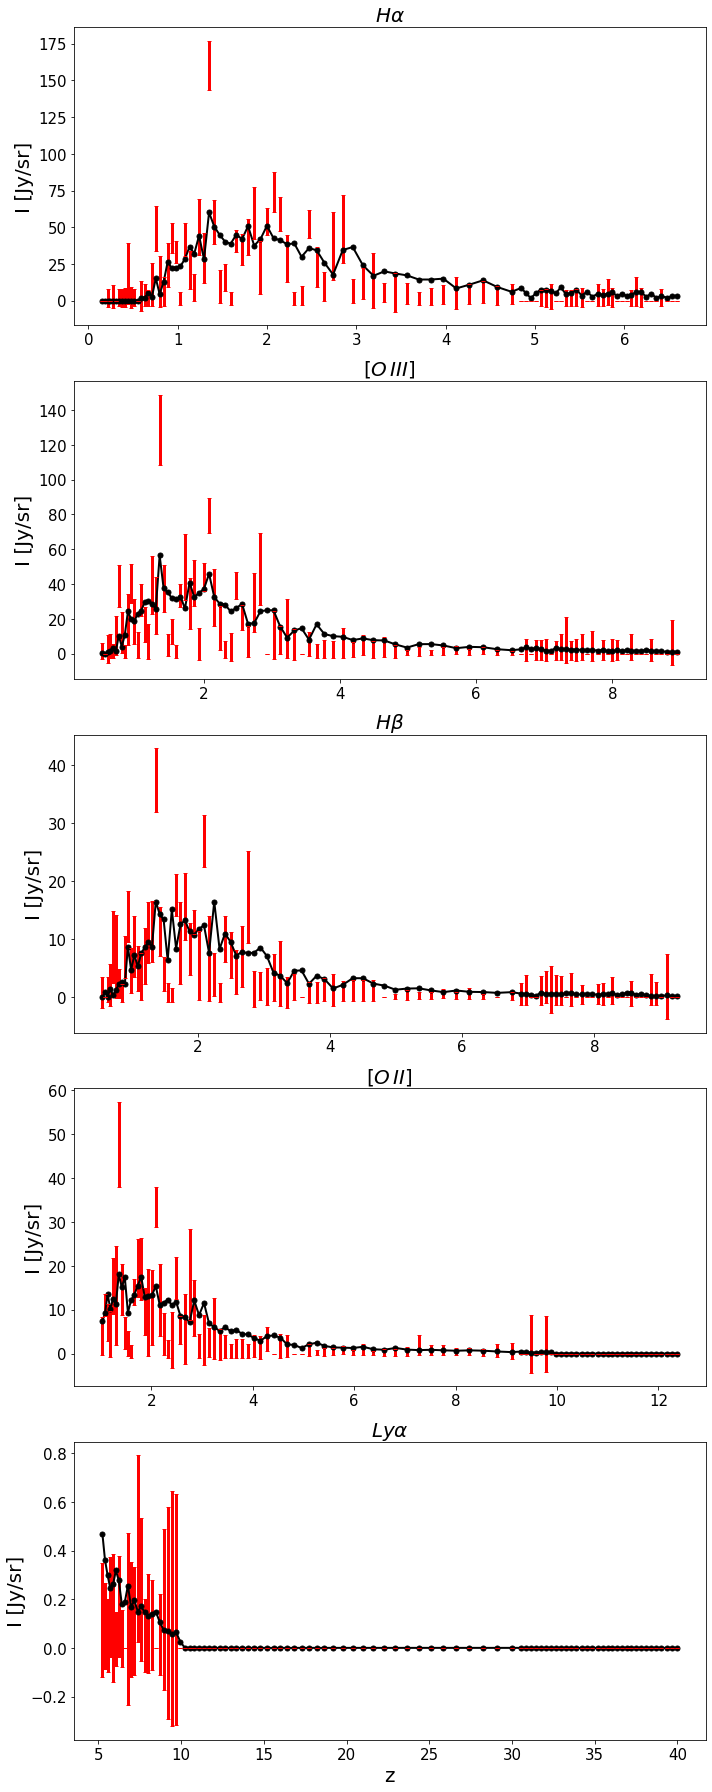

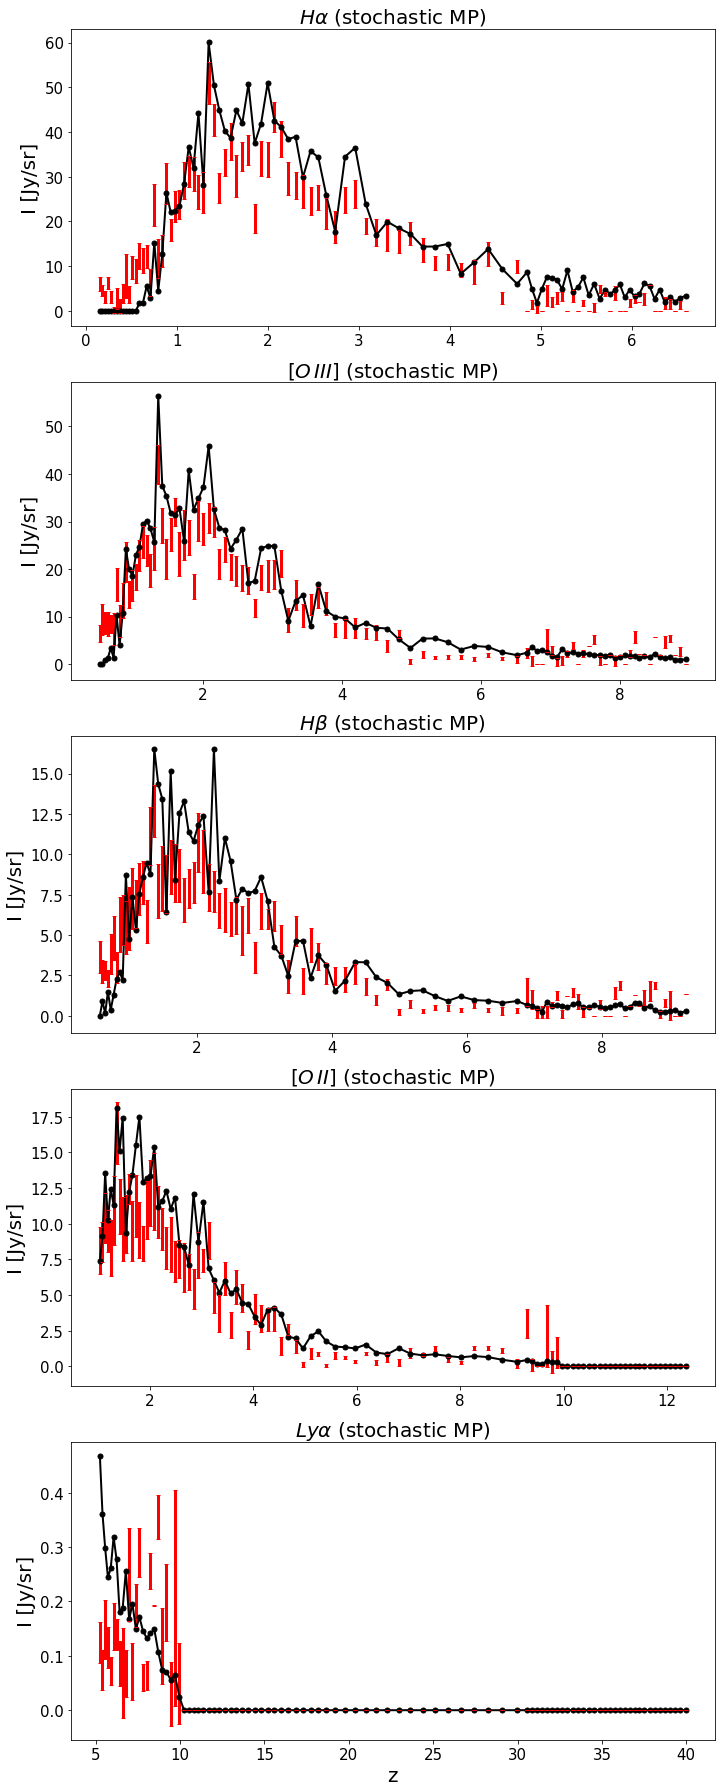

In [406]:
x.load_observations()

p = x.show_result1(ip_3sig, N_lc=500, stochastic=False)
# x.plot_correlation_coeffs_sphx(ip_3sig, N_lc=50)

x.load_observations()

p = x.show_result1(ip_3sig_st, N_lc=500, stochastic=True)
# x.plot_correlation_coeffs_sphx(ip_3sig_st, N_lc=50)

In [410]:
ip_3sig_int, f_arr, iter_ct_no_stoch_int, _ = x.sim_noise(nsims=10, N_lc=2500, amp_nsigma=3., iter_max=10, show_iter_plots=False, stochastic=False, fast_lines=False)
ip_3sig_st_int, f_arr, iter_ct_no_stoch_int, _ = x.sim_noise(nsims=10, N_lc=2500, amp_nsigma=3., iter_max=10, show_iter_plots=False, stochastic=True, fast_lines=False)


Ipred targ has shape  (10, 5, 2500, 96)
specific lines has shape (2500, 96)
specific lines has shape (2500, 96)
specific lines has shape (2500, 96)
specific lines has shape (2500, 96)
specific lines has shape (2500, 96)
specific lines has shape (2500, 96)
specific lines has shape (2500, 96)
specific lines has shape (2500, 96)
specific lines has shape (2500, 96)
specific lines has shape (2500, 96)
Ipred targ has shape  (10, 5, 2500, 96)
specific lines has shape (2500, 96)
i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9


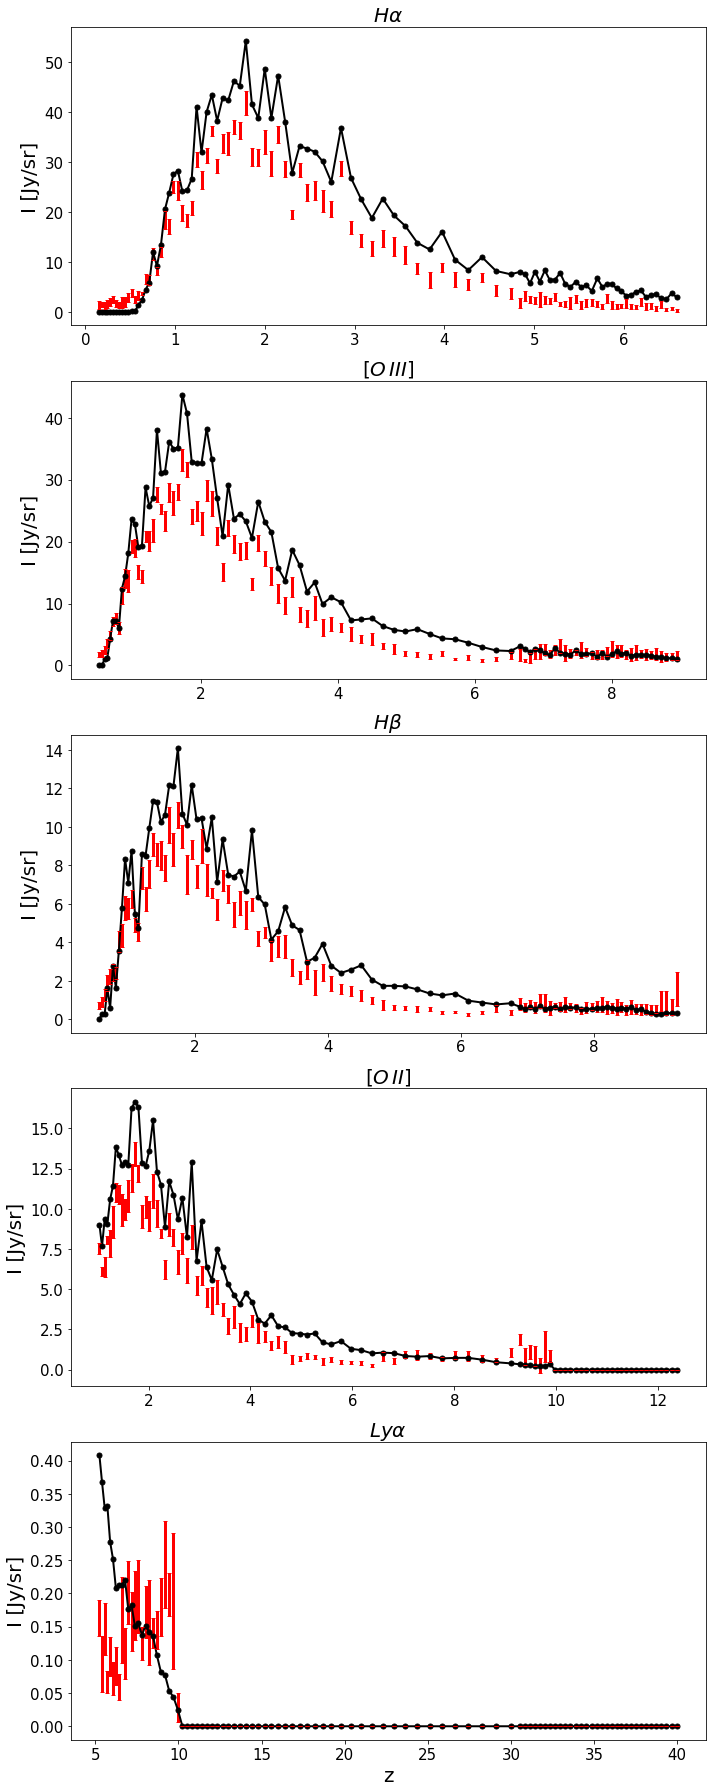

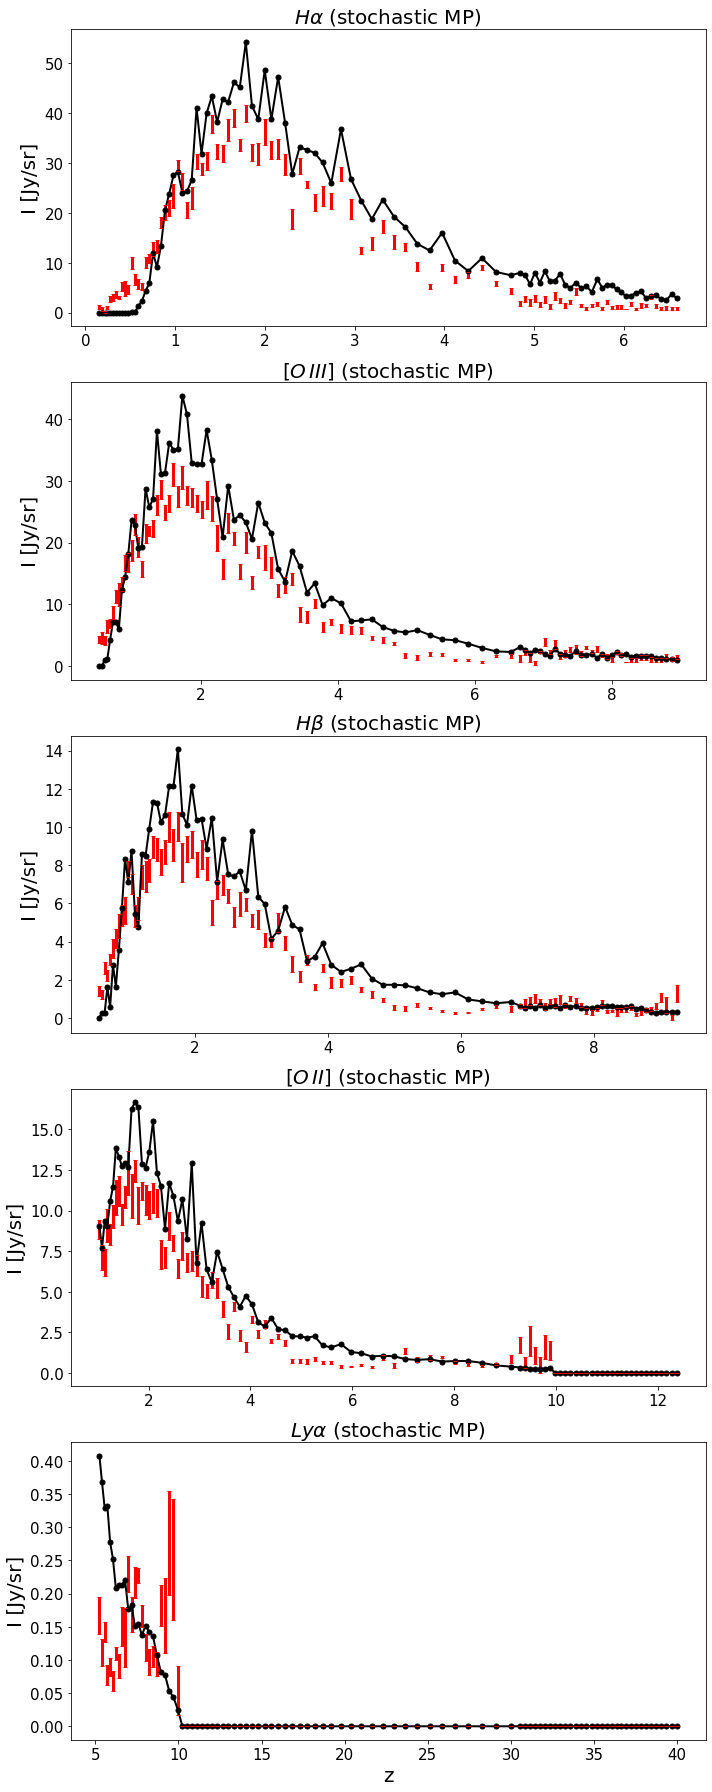

In [411]:
x.load_observations()

p = x.show_result1(ip_3sig_int, N_lc=2500, stochastic=False)
# x.plot_correlation_coeffs_sphx(ip_3sig, N_lc=50)

x.load_observations()

p = x.show_result1(ip_3sig_st_int, N_lc=2500, stochastic=True)

In [30]:
# x.load_observations()

# x.show_result1(ip_3sig, N_lc=2500)
# x.plot_correlation_coeffs_sphx(ip_3sig, N_lc=2500)

# x.load_observations()

# x.show_result1(ip_3sig_st, N_lc=2500)
# x.plot_correlation_coeffs_sphx(ip_3sig_st, N_lc=2500)

[[[[ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   ...
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]]

  [[ 0.          0.         -1.21191488 ...  0.          0.
    -2.1383707 ]
   [ 0.          0.         -1.21191488 ...  0.          0.
    -2.1383707 ]
   [ 0.          0.         -1.21191488 ...  0.          0.
    -2.1383707 ]
   ...
   [ 0.          0.         -1.21191488 ...  0.          0.
    -2.1383707 ]
   [ 0.          0.         -1.21191488 ...  0.          0.
    -2.1383707 ]
   [ 0.          0.         -1.21191488 ...  0.          0.
    -2.1383707 ]]

  [[-0.38854735  0.         -0.97672112 ...  0.          0

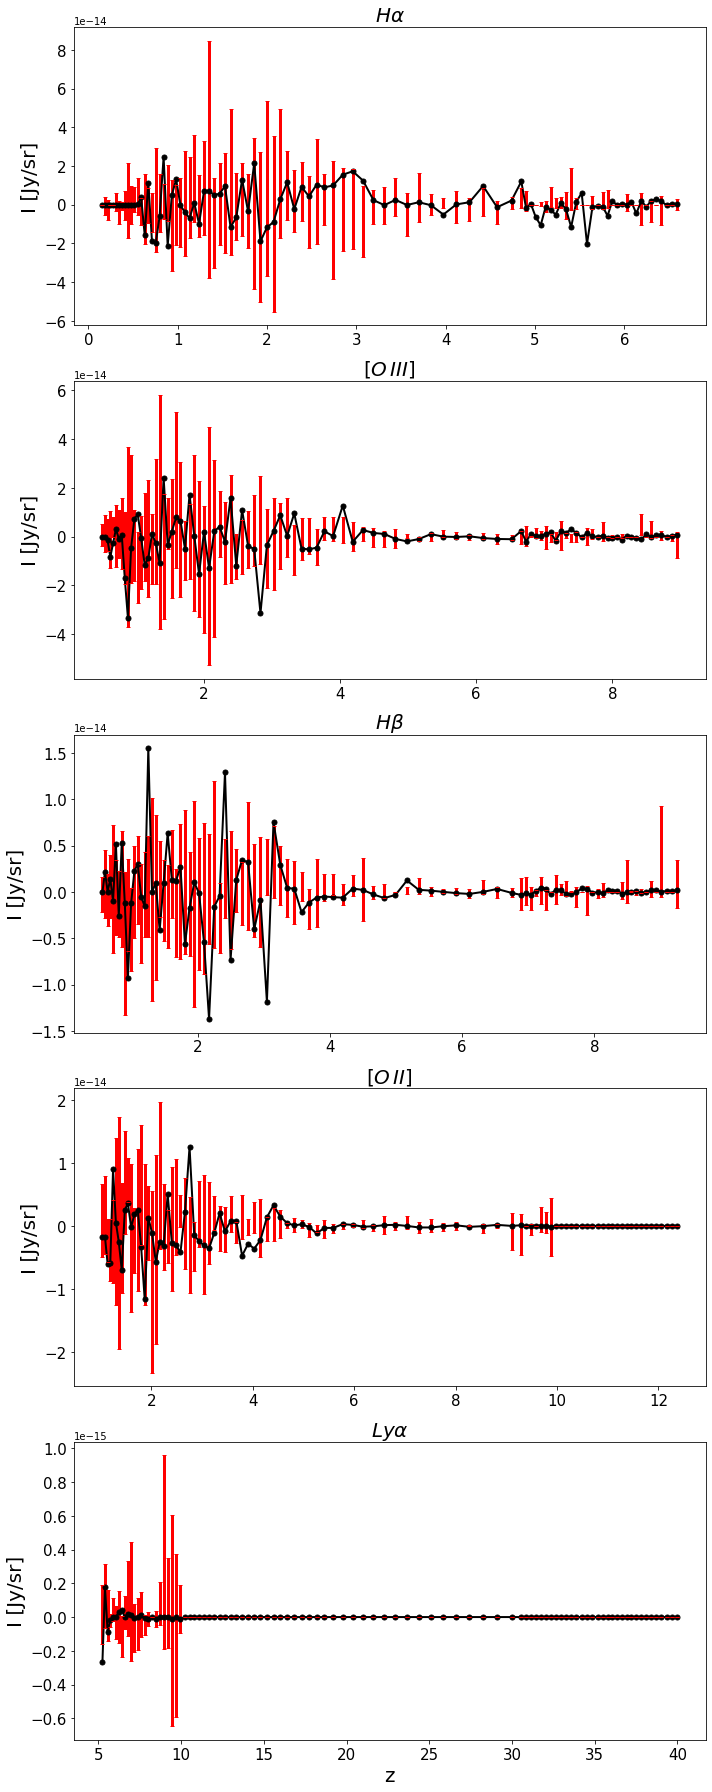

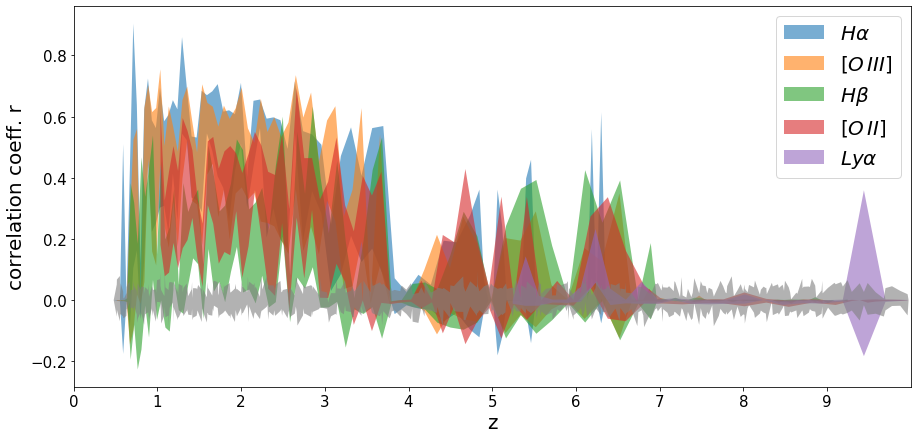

In [562]:
# print(ip_3sig_st)
# print(x.Itrue_targ.shape)
x.show_result1(ip_3sig_st, N_lc=500)
x.plot_correlation_coeffs_sphx(ip_3sig_st, N_lc=500)

In [520]:
ip, f_arr, iter_ct_no_stoch = x.sim_noise(nsims=10, N_lc=2500, iter_max=10, show_iter_plots=False, stochastic=True, fast_lines=False)


Ipred targ has shape  (10, 5, 2500, 96)
time elapsed for slow version is  1.2408580780029297
i =  0
time elapsed for slow version is  1.0262410640716553
i =  1
time elapsed for slow version is  1.000910758972168
i =  2
time elapsed for slow version is  1.2944819927215576
i =  3
time elapsed for slow version is  1.1827688217163086
i =  4
time elapsed for slow version is  1.1493258476257324
i =  5
time elapsed for slow version is  1.1580750942230225
i =  6
time elapsed for slow version is  1.0464699268341064
i =  7
time elapsed for slow version is  1.0266430377960205
i =  8
time elapsed for slow version is  1.0279123783111572
i =  9


(10, 5, 2500, 96)
(5, 2500, 96)


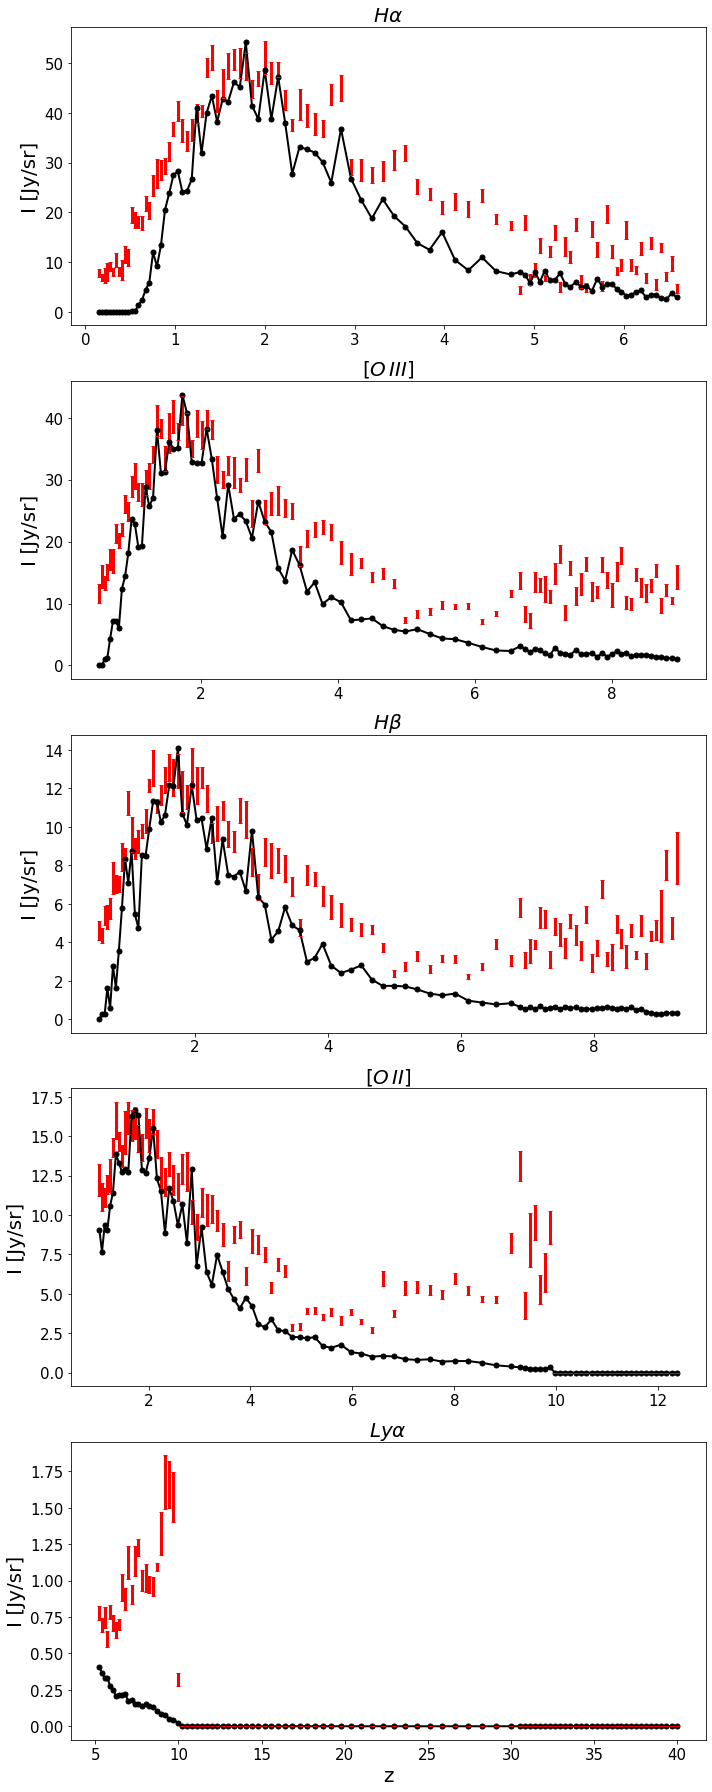

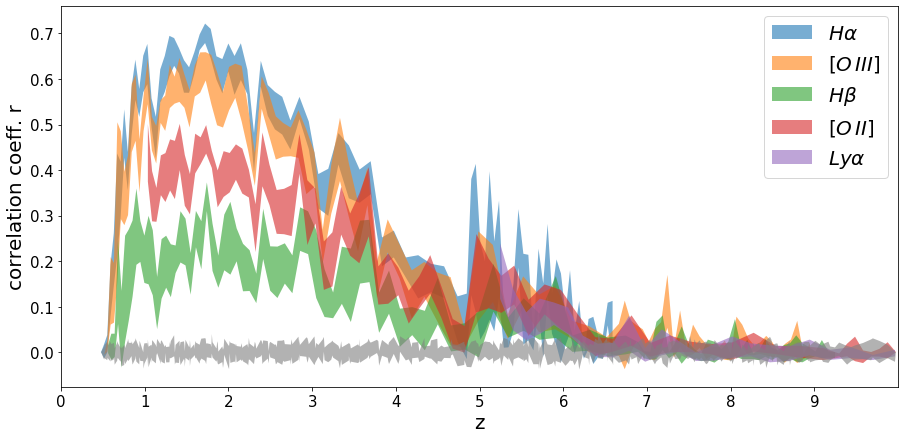

In [521]:
print(ip.shape)
print(x.Itrue_targ.shape)
x.show_result1(ip)
x.plot_correlation_coeffs_sphx(ip)

In [511]:
ip, f_arr, iter_ct_no_stoch = x.sim_noise(nsims=50, N_lc=500, iter_max=15, show_iter_plots=False, stochastic=True, fast_lines=False)


Ipred targ has shape  (50, 5, 500, 96)
time elapsed for slow version is  0.3163447380065918
time elapsed for slow version is  0.23009014129638672
time elapsed for slow version is  0.22601819038391113
time elapsed for slow version is  0.23104214668273926
time elapsed for slow version is  0.21993708610534668
time elapsed for slow version is  0.31174707412719727
time elapsed for slow version is  0.23354816436767578
time elapsed for slow version is  0.23645615577697754
time elapsed for slow version is  0.22846221923828125
time elapsed for slow version is  0.23197579383850098
time elapsed for slow version is  0.22970128059387207
time elapsed for slow version is  0.22223901748657227
time elapsed for slow version is  0.23357295989990234
time elapsed for slow version is  0.24324798583984375
time elapsed for slow version is  0.23091387748718262
time elapsed for slow version is  0.24029898643493652
time elapsed for slow version is  0.22469186782836914
time elapsed for slow version is  0.22564792

(50, 5, 500, 96)
(5, 2500, 96)


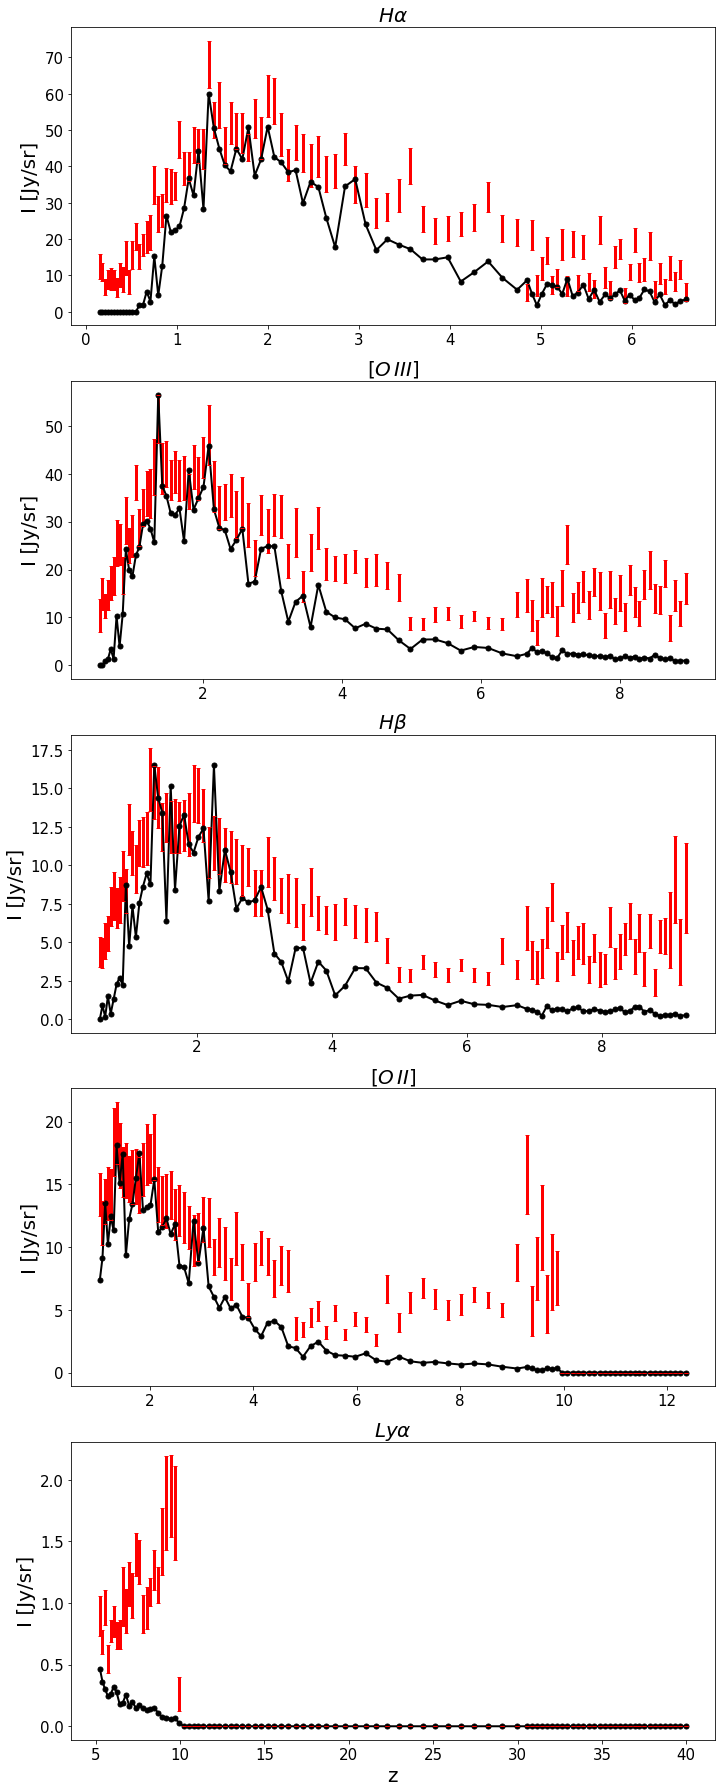

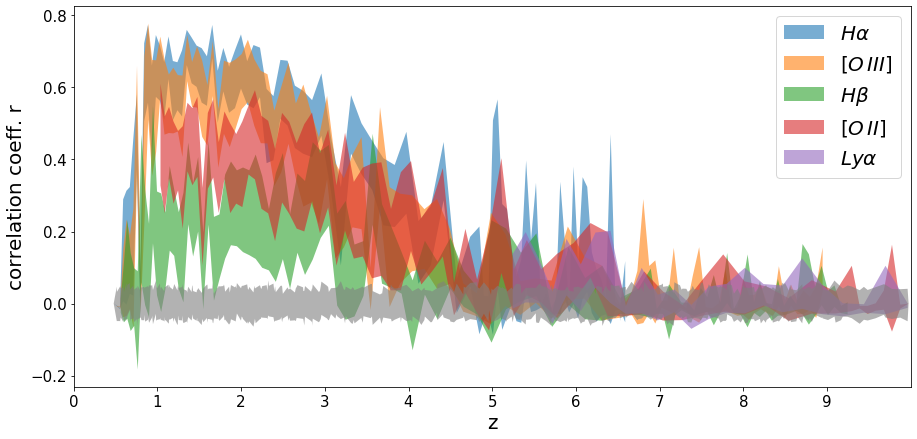

In [517]:
print(ip.shape)
print(x.Itrue_targ.shape)
x.show_result1(ip, N_lc=500)
x.plot_correlation_coeffs_sphx(ip, N_lc=500)

In [ ]:
def compare_greedy_stochastic_mp_individual_line(nuidxs, Itrue_line, Iobs_line, f_arr_greedy, f_arrs_st, noise=None, nsigma_th=3.0, return_fig=True):
    
    fig = plt.figure(figsize=(8, 8))
    plt.suptitle(str(nsigma_th)+'$\\sigma$ threshold', fontsize=20, y=1.03)
    
    plt.subplot(3,1,1)
    plt.title('Greedy Matched Pursuit', fontsize=14)
    plt.plot(nuidxs, Itrue_line, color='k', label='truth', linewidth=4, marker='.')
    plt.plot(nuidxs, Iobs_line, label='observed', linewidth=2, color='g', linestyle='dashed')
    if noise is not None:
        plt.plot(nuidxs, noise, color='grey', label='noise')
    plt.plot(nuidxs, f_arr_greedy, label='Greedy recon.', color='r', linewidth=1)
    plt.xlabel('$\\nu$ index', fontsize=14)
    plt.ylabel('I [Jy/sr]', fontsize=14)
    plt.legend()
    
    plt.subplot(3,1,2)
    plt.title('Stochastic Matched Pursuit (Shaded regions bound 16th and 84th pcts.)', fontsize=14)
    plt.plot(nuidxs, Itrue_line, color='k', label='truth', linewidth=4, marker='.')
    plt.plot(nuidxs, Iobs_line, label='observed', linewidth=2, color='g', linestyle='dashed')
    if noise is not None:
        plt.plot(nuidxs, noise, color='grey', label='noise')
    plt.plot(nuidxs, np.median(f_arrs_st, axis=0), color='C0', label='Median stochastic recon.', linewidth=1)
    plt.fill_between(nuidxs, np.percentile(f_arrs_st, 16, axis=0), np.percentile(f_arrs_st, 84, axis=0),color='C0', alpha=0.5)
    plt.legend()
    plt.xlabel('$\\nu$ index', fontsize=14)
    plt.ylabel('I [Jy/sr]', fontsize=14)
    
    plt.subplot(3,1,3)
    plt.title('Residuals', fontsize=14)
    plt.plot(nuidxs, np.median(f_arrs_st, axis=0)-Itrue_line, color='C0', label='Stochastic', linewidth=2, zorder=10)
    plt.fill_between(nuidxs, np.percentile(f_arrs_st, 16, axis=0)-Itrue_line, np.percentile(f_arrs_st, 84, axis=0)-Itrue_line, color='C0', alpha=0.5)
    plt.plot(nuidxs, f_arr_greedy-Itrue_line, color='r', label='Greedy', linewidth=2)
    if noise is not None:
        plt.plot(nuidxs, noise, color='grey', label='noise')
    plt.legend()
    plt.xlabel('$\\nu$ index', fontsize=14)
    plt.ylabel('I [Jy/sr]', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    if return_fig:
        return fig

    
    
    

sim got a list
Ipred targ has shape  (1, 5, 1, 96)
specific lines has shape (1, 96)
sim got a list
Ipred targ has shape  (100, 5, 1, 96)
specific lines has shape (1, 96)
(100, 96)


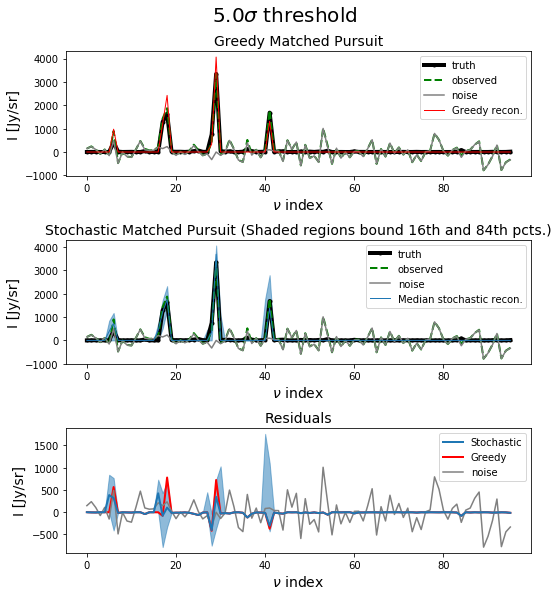

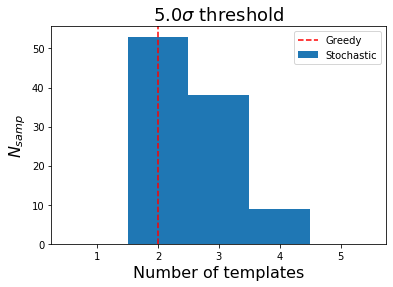

In [388]:
nsigma_th = 5.
ip, f_arr, iter_ct_no_stoch, Iobs_specific_lines_nost = x.sim_noise(nsims=1, N_lc=[0], amp_nsigma=nsigma_th, show_iter_plots=False, stochastic=False, fast_lines=False)

# print('stochastic is')
ip, f_arrs, iter_cts, Iobs_specific_lines_st = x.sim_noise(nsims=100, N_lc=[0], amp_nsigma=nsigma_th, show_iter_plots=False, stochastic=True, fast_lines=False)

# print(f_arrs)
f_arrs = np.array(f_arrs)

print(f_arrs.shape)

nuidxs = np.arange(f_arrs.shape[-1])

plt.figure(figsize=(8, 8))
plt.suptitle(str(nsigma_th)+'$\\sigma$ threshold', fontsize=20, y=1.03)
plt.subplot(3,1,1)
plt.title('Greedy Matched Pursuit', fontsize=14)
plt.plot(nuidxs, x.Itrue_all[0], color='k', label='truth', linewidth=4, marker='.')
plt.plot(nuidxs, Iobs_specific_lines_nost[0], label='observed', linewidth=2, color='g', linestyle='dashed')

plt.plot(nuidxs, x.noise[0], color='grey', label='noise')
plt.plot(nuidxs, f_arr[0], label='Greedy recon.', color='r', linewidth=1)
plt.xlabel('$\\nu$ index', fontsize=14)
plt.ylabel('I [Jy/sr]', fontsize=14)
plt.legend()
plt.subplot(3,1,2)
plt.title('Stochastic Matched Pursuit (Shaded regions bound 16th and 84th pcts.)', fontsize=14)
plt.plot(nuidxs, x.Itrue_all[0], color='k', label='truth', linewidth=4, marker='.')
plt.plot(nuidxs, Iobs_specific_lines_st[0], label='observed', linewidth=2, color='g', linestyle='dashed')
plt.plot(nuidxs, x.noise[0], color='grey', label='noise')
plt.plot(nuidxs, np.median(f_arrs, axis=0), color='C0', label='Median stochastic recon.', linewidth=1)
plt.fill_between(nuidxs, np.percentile(f_arrs, 16, axis=0), np.percentile(f_arrs, 84, axis=0),color='C0', alpha=0.5)
plt.legend()
plt.xlabel('$\\nu$ index', fontsize=14)
plt.ylabel('I [Jy/sr]', fontsize=14)
plt.subplot(3,1,3)
plt.title('Residuals', fontsize=14)
plt.plot(nuidxs, np.median(f_arrs, axis=0)-x.Itrue_all[0], color='C0', label='Stochastic', linewidth=2, zorder=10)
plt.fill_between(nuidxs, np.percentile(f_arrs, 16, axis=0)-x.Itrue_all[0], np.percentile(f_arrs, 84, axis=0)-x.Itrue_all[0], color='C0', alpha=0.5)
plt.plot(nuidxs, f_arr[0]-x.Itrue_all[0], color='r', label='Greedy', linewidth=2)
plt.plot(nuidxs, x.noise[0], color='grey', label='noise')
plt.legend()
plt.xlabel('$\\nu$ index', fontsize=14)
plt.ylabel('I [Jy/sr]', fontsize=14)
plt.tight_layout()
plt.savefig('figures/greedy_vs_stochastic_lightcone_idx0_'+str(int(nsigma_th))+'sigth_9_8_20.png', dpi=200, bbox_inches='tight')
plt.show()

plt.figure()
plt.title(str(nsigma_th)+'$\\sigma$ threshold', fontsize=18)
plt.hist(np.array(iter_cts).ravel(), bins=np.arange(np.min(iter_cts)-2, np.max(iter_cts)+2)+0.5, histtype='stepfilled', label='Stochastic')
plt.axvline(iter_ct_no_stoch[0][0], color='r', linestyle='dashed', label='Greedy')
plt.xlabel('Number of templates', fontsize=16)
plt.ylabel('$N_{samp}$', fontsize=16)
plt.legend()
plt.savefig('figures/greedy_vs_stochastic_lightcone_idx0_'+str(int(nsigma_th))+'sigth_ncomp_9_8_20.png', bbox_inches='tight')
plt.show()
# x.show_result1(ip)

## load dictionary

In [ ]:
# A, I_norm, z_coords, N_nu, N_z, z_coords_all, z_idx, I_coords_all \
# = sparse_dict(dth, nu_binedges, line_use, model = model)

# with open('data_internal/sparse_be13_dict.pickle','wb') as pfile:
#     pickle.dump([A, I_norm, z_coords, N_nu, N_z, z_coords_all, z_idx, I_coords_all],pfile)

In [135]:
with open('data_internal/sparse_be13_dict.pickle','rb') as pfile:
    A, I_norm, z_coords, N_nu, N_z, z_coords_all, z_idx, I_coords_all = pickle.load(pfile)

## load sim data

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


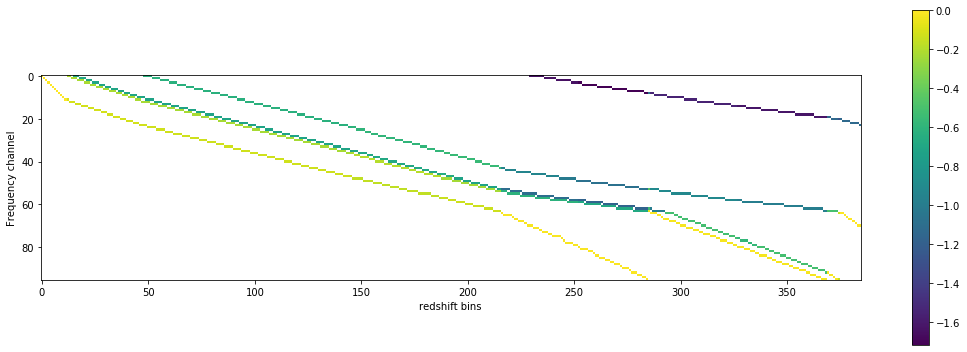

In [136]:
plt.figure(figsize=(15, 5))
plt.imshow(np.log10(A))
plt.colorbar()
plt.ylabel('Frequency channel')
plt.xlabel('redshift bins')
plt.tight_layout()
# plt.title('Normalized Dictionary Templates')
plt.show()

In [3]:
# # skip this cell, load the pickle
# N_true0, Itrue_all0, Itrue_targ0 = gen_lightcone(N_lc*4, dth, nu_binedges, z_coords_all, \
#                       I_coords_all, z_idx, line_use, line_targ_vec, model = model)
# N_true = N_true0[::4,:] + N_true0[1::4,:] + N_true0[2::4,:] + N_true0[3::4,:]
# Itrue_all = (Itrue_all0[::4,:] + Itrue_all0[1::4,:] + Itrue_all0[2::4,:] + \
#              Itrue_all0[3::4,:]) / 4
# Itrue_targ = (Itrue_targ0[:,::4,:] + Itrue_targ0[:,1::4,:] +\
#               Itrue_targ0[:,2::4,:] + Itrue_targ0[:,3::4,:]) / 4

# with open('data_internal/sparse_be13_general.pickle','wb') as pfile:
#     pickle.dump([N_true, Itrue_all, Itrue_targ], pfile)

In [73]:
with open('data_internal/sparse_be13_general_Lr.pickle','rb') as pfile:
    N_true, Itrue_all, Itrue_targ = pickle.load(pfile)

## Run MP

In [75]:
def run_MP2(A, I_norm, Iobs_all, e_th, iter_max = 10, stochastic=False):
    

    N_nu, N_z = A.shape # number of frequency channels, number of redshifts?
    N_lc = Iobs_all.shape[0] # number of light curves
    N_pred = np.zeros([N_lc, N_z]) # predicted N
    
    print('N_nu, N_z:', N_nu, N_z)
    
    print('N_lc:', N_lc)
    
    

    for ilc in range(N_lc):
        R_arr = Iobs_all[ilc].copy()
        R = np.sqrt(np.mean(R_arr**2)) # the initial residual is the RMS of the component
        f_arr = np.zeros(N_nu)
        NI_arr = np.zeros(N_z)
        iter_count = 0
        # start the MP algorithm
        while True:
            # if residual is less than epsilon threshold or iteration counter reaches max, end it
            if (R < e_th) or iter_count == iter_max:
                break
            iter_count += 1
            # choose the dictionary element with the largest inner product

            if stochastic:
                dots = np.dot(R_arr.reshape(1, -1), A)
                gamma = np.random.choice(np.arange(dots.shape[0]), p=dots/np.sum(dots))
            else:
                gamma = np.argmax(np.dot(R_arr.reshape(1,-1), A)[0])
            # 
            amp = np.sum(A[:,gamma] * R_arr)
            # multiply the amplitude by the normalized template
            u = amp * A[:,gamma]

            NI_arr[gamma] += amp
            # subtract largest inner product from residual
            R_arr -= u
            f_arr += u
            R = np.sqrt(np.mean(R_arr**2))

        N_pred[ilc,:] = NI_arr / I_norm
        #print('Light cone %d MP end in %d iterations.'%(ilc, iter_count))
    return N_pred



(96,)


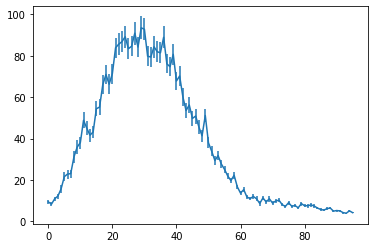

In [44]:
print(np.mean(Itrue_all, axis=0).shape)
plt.figure()
plt.errorbar(np.arange(Itrue_all.shape[1]), np.mean(Itrue_all, axis=0), yerr=np.std(Itrue_all, axis=0)/np.sqrt(Itrue_all.shape[0]))
plt.show()

In [60]:
print(A.shape, Iobs_all.shape, Itrue_all.shape, Itrue_targ.shape, I_norm.shape)

(96, 385) (2500, 96) (2500, 96) (5, 2500, 96) (385,)


In [177]:
sigI0 = 3631 * 10**(-22  /2.5) / 5 / dOm / np.sqrt(4) # pixel NEI
sigI = sigI0 / np.sqrt(4)
e_th = sigI * 0.97

N_sim = 2
Ipred_targ_arr = np.zeros([N_sim]+list(Itrue_targ.shape))
for i in range(N_sim):
    print('i = ', i)
    Iobs_all = Itrue_all + np.random.normal(0, sigI, Itrue_all.shape)
    
    # run the matched pursuit algorithm, beginning with A, the sparse dictionary
    N_pred = run_MP2(A, I_norm / 4, Iobs_all, e_th)
    _, Ipred_targ = gen_Ipred\
        (z_coords, N_pred, dth*2, nu_binedges, line_use, line_targ_vec, model = model, verbose = 0)
    Ipred_targ_arr[i] = Ipred_targ

i =  0
N_nu, N_z: 96 385
N_lc: 2500
i =  1
N_nu, N_z: 96 385
N_lc: 2500


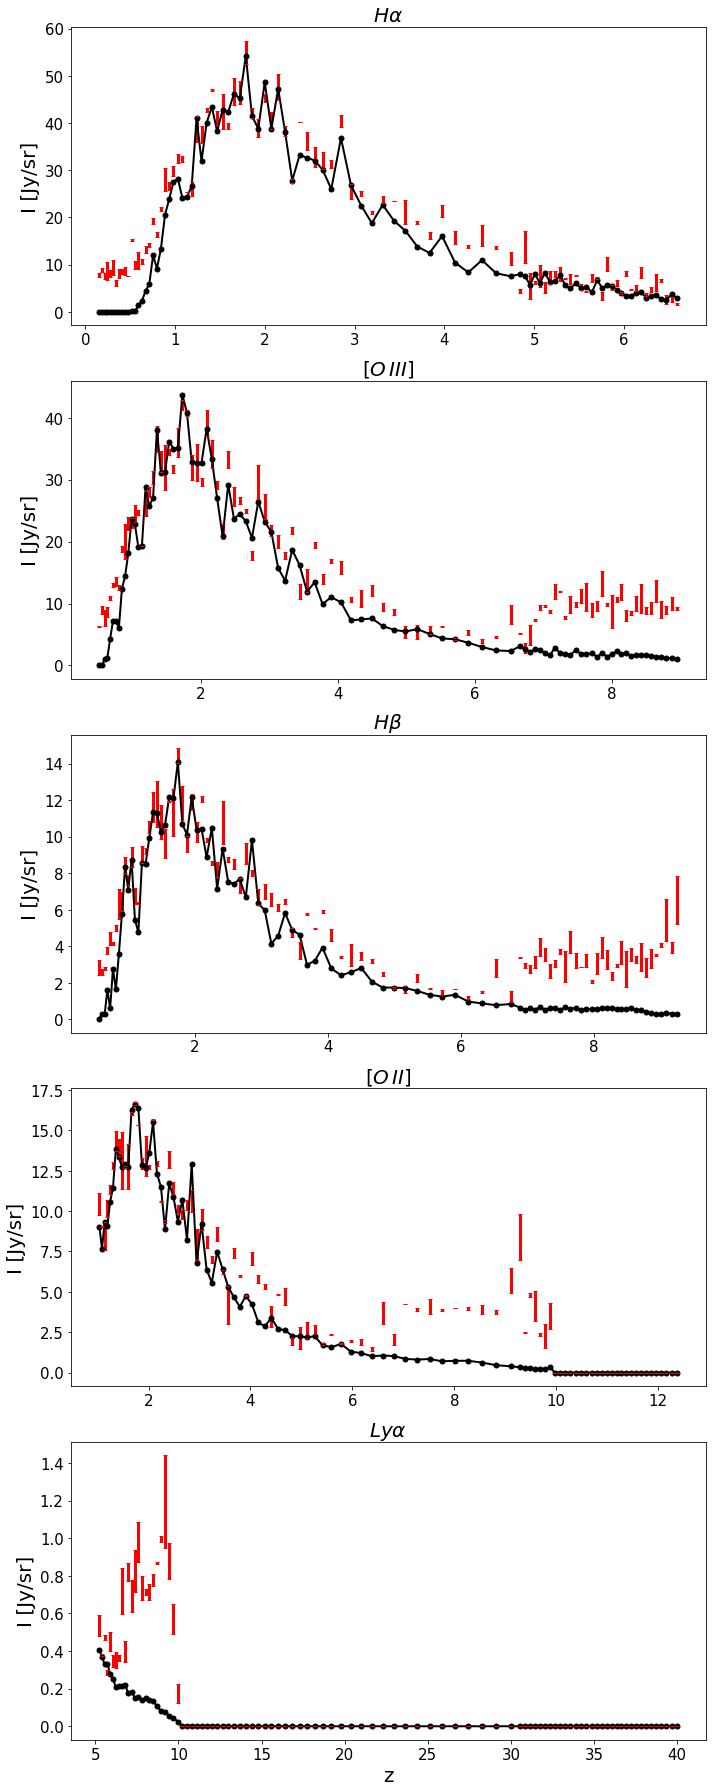

In [178]:
nu0_arr = [spec_lines.Ha.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.OIII.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.Hb.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.OII.to(u.GHz, equivalencies=u.spectral()).value,\
           spec_lines.Lya.to(u.GHz, equivalencies=u.spectral()).value]

fig, ax = plt.subplots(5, 1, figsize = (10,25))

for jtarg, (nu0, line_name) in enumerate(zip(nu0_arr, line_name_arr)):
    zbins = nu0 / sphx_par.nu_bins - 1
    mu_true = np.mean(Itrue_targ[jtarg,:,:], axis=0)
    ax[jtarg].plot(zbins, mu_true, 'ko-', markersize = 5, lw = 2)
    
    mus_pred = np.mean(Ipred_targ_arr[:,jtarg,:,:], axis = 1)
    mu_pred = np.mean(mus_pred, axis = 0)
    sig = np.std(mus_pred, axis = 0)
    ax[jtarg].errorbar(zbins, mu_pred, sig, c = 'r', fmt = 'none', capsize = 2, lw = 3)
    ax[jtarg].set_title(line_name, fontsize = 20)
    ax[jtarg].tick_params(axis='both', which='major', labelsize=15)
    ax[jtarg].set_ylabel('I [Jy/sr]', fontsize = 20)
ax[4].set_xlabel('z', fontsize = 20)
fig.tight_layout()
# plt.savefig('plots/paperfig/Full_I.pdf', bbox_inches = 'tight', dpi = 300)

Ha, z = 0.40, Itrue = 0.509, Ipred = 9.308 +- 0.434, err = 1728.29% 
Ha, z = 1.07, Itrue = 25.622, Ipred = 29.941 +- 0.052, err = 16.85% 
Ha, z = 2.05, Itrue = 39.965, Ipred = 40.720 +- 0.054, err = 1.89% 
Ha, z = 3.67, Itrue = 17.341, Ipred = 21.163 +- 0.445, err = 22.04% 
Ha, z = 5.27, Itrue = 6.343, Ipred = 6.955 +- 0.008, err = 9.65% 
Ha, z = 6.17, Itrue = 3.822, Ipred = 5.167 +- 0.036, err = 35.19% 
OIII, z = 0.83, Itrue = 11.585, Ipred = 16.319 +- 0.215, err = 40.87% 
OIII, z = 1.71, Itrue = 33.803, Ipred = 33.861 +- 0.038, err = 0.17% 
OIII, z = 3.00, Itrue = 19.553, Ipred = 21.707 +- 0.045, err = 11.01% 
OIII, z = 5.12, Itrue = 5.750, Ipred = 8.339 +- 0.318, err = 45.04% 
OIII, z = 7.21, Itrue = 2.164, Ipred = 8.745 +- 0.457, err = 304.02% 
OIII, z = 8.39, Itrue = 1.604, Ipred = 9.932 +- 0.050, err = 519.10% 
Hb, z = 0.89, Itrue = 4.252, Ipred = 5.918 +- 0.071, err = 39.20% 
Hb, z = 1.79, Itrue = 10.753, Ipred = 10.887 +- 0.027, err = 1.24% 
Hb, z = 3.12, Itrue = 5.936, Ipred =

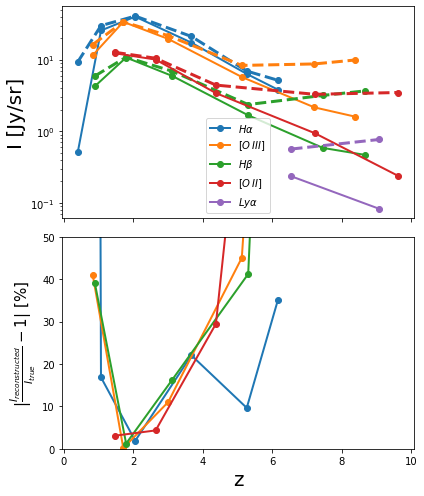

In [513]:
#
from matplotlib import gridspec

fig = plt.figure(figsize=[6,7])
gs = gridspec.GridSpec(2, 1, height_ratios=[1,1]) 
ax1= plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex = ax1)

for jtarg, (nu0, line_name,i,j) in enumerate(zip(nu0_arr, line_name_arr,[0,0,0,1,1],[0,1,2,0,1])):
    zbins = nu0 / sphx_par.nu_bins - 1
    mu_true = np.mean(Itrue_targ[jtarg,:,:], axis=0)    
    mus_pred = np.mean(Ipred_targ_arr[:,jtarg,:,:], axis = 1)
    mu_pred = np.mean(mus_pred, axis = 0)
    sig = np.std(mus_pred, axis = 0)
    bz = []
    bmu_true = []
    bmu_pred = []
    bsig_pred = []
    for iband in range(6):
        band_zbins = zbins[16*iband:16*(iband+1)]
        band_mu_true = mu_true[16*iband:16*(iband+1)]
        band_mus_pred = mus_pred[:,16*iband:16*(iband+1)]
        sp = np.where(band_zbins < 10)[0]
        band_zbins = band_zbins[sp]
        band_mu_true = band_mu_true[sp]
        band_mus_pred = band_mus_pred[:,sp]
        if len(sp) != 0:
            bz.append(np.mean(band_zbins))
            bmu_true.append(np.mean(band_mu_true))
            band_mus_pred = np.mean(band_mus_pred, axis = 1)
            bmu_pred.append(np.mean(band_mus_pred))
            bsig_pred.append(np.std(band_mus_pred))
            err = (np.mean(band_mus_pred) - np.mean(band_mu_true)) / np.mean(band_mu_true)
            print('%s, z = %.2f, Itrue = %.3f, Ipred = %.3f +- %.3f, err = %.2f%% '\
                  %(line_use[jtarg],np.mean(band_zbins),np.mean(band_mu_true),\
                    np.mean(band_mus_pred),np.std(band_mus_pred), err*100))
    line = ax1.plot(bz, bmu_true,'o-', lw = 2, label = line_name)
    ax1.errorbar(bz, bmu_pred, bsig_pred, c = line[0].get_color(), fmt = 'none', capsize = 2, lw = 3)
    ax1.plot(bz, bmu_pred, 'o--', c = line[0].get_color(), lw = 3)
    err_arr = (np.array(bmu_pred) - np.array(bmu_true)) / np.array(bmu_true)
    ax2.plot(bz, np.abs(err_arr) * 100, 'o-', lw = 2, label = line_name)
    
ax1.set_ylabel('I [Jy/sr]', fontsize = 20)
ax1.tick_params(axis='both', which='major', labelsize=10)
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_yscale('log')
ax1.legend(loc = 0, fontsize = 10)
ax2.set_xlabel('z', fontsize = 20)
ax2.set_ylabel(r'$|\frac{I_{reconstructed}}{I_{true}} - 1|$ [%]', fontsize = 15)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.set_ylim([0,50])

plt.subplots_adjust(hspace=.0)
fig.tight_layout()
# plt.savefig('plots/paperfig/Full_I_band.pdf', bbox_inches = 'tight', dpi = 300)

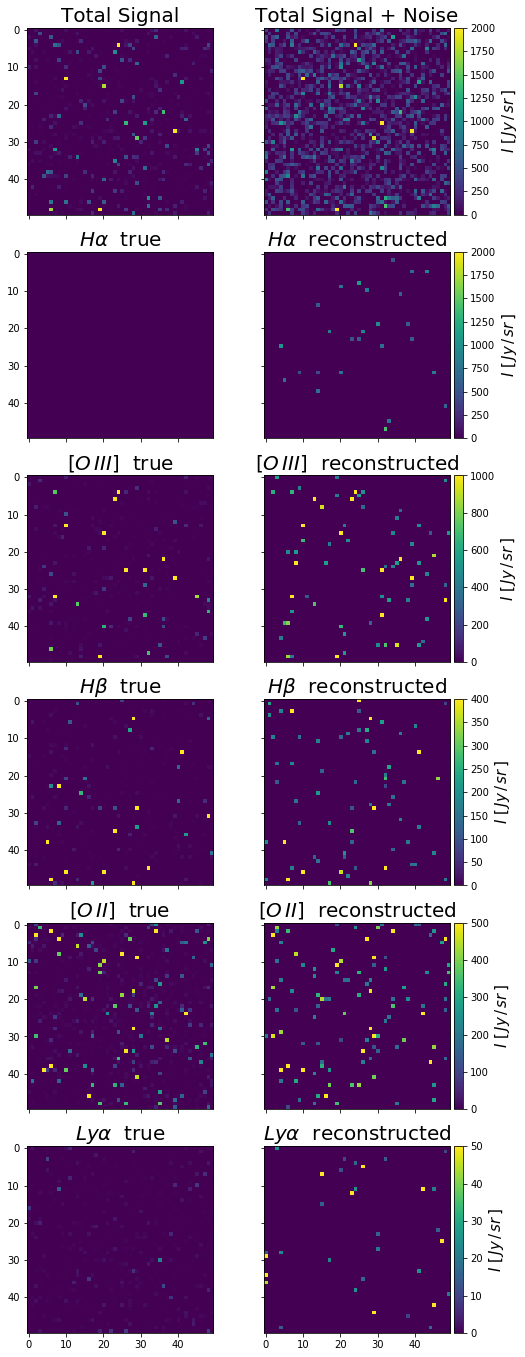

In [53]:
#
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(6,2, figsize = (8,24))
img1 = ax[0][0].imshow(Itrue_all[:,8].reshape(50,50), vmin = 0, vmax = 2000)
img2 = ax[0][1].imshow(Iobs_all[:,8].reshape(50,50), vmin = 0, vmax = 2000)
divider = make_axes_locatable(ax[0][1])
cax2 = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(img2, cax=cax2)
cbar.set_label(r'$I\,\,[\,Jy\, /\, sr\,]$', fontsize = 15)
ax[0][0].set_title('Total Signal', fontsize = 20)
ax[0][1].set_title('Total Signal + Noise', fontsize = 20)
ax[0][1].get_yaxis().set_ticklabels([])
ax[0][0].get_xaxis().set_ticklabels([])
ax[0][1].get_xaxis().set_ticklabels([])
        
for i,vmax in enumerate([2000,1000,400,500,50]):
    img1 = ax[i+1][0].imshow(Itrue_targ[i,:,8].reshape(50,50), vmin = 0, vmax = vmax)
    img2 = ax[i+1][1].imshow(Ipred_targ_arr[-1,i,:,8].reshape(50,50), vmin = 0, vmax = vmax)
    divider = make_axes_locatable(ax[i+1][1])
    cax2 = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(img2, cax=cax2)
    cbar.set_label(r'$I\,\,[\,Jy\, /\, sr\,]$', fontsize = 15)
    ax[i+1][0].set_title(line_name_arr[i] + '  true', fontsize = 20)
    ax[i+1][1].set_title(line_name_arr[i] + '  reconstructed', fontsize = 20)
    ax[i+1][1].get_yaxis().set_ticklabels([])
    if i != len(line_use) - 1:
        ax[i+1][0].get_xaxis().set_ticklabels([])
        ax[i+1][1].get_xaxis().set_ticklabels([])

# plt.savefig('plots/paperfig/Full_im.pdf', bbox_inches = 'tight', dpi = 300)

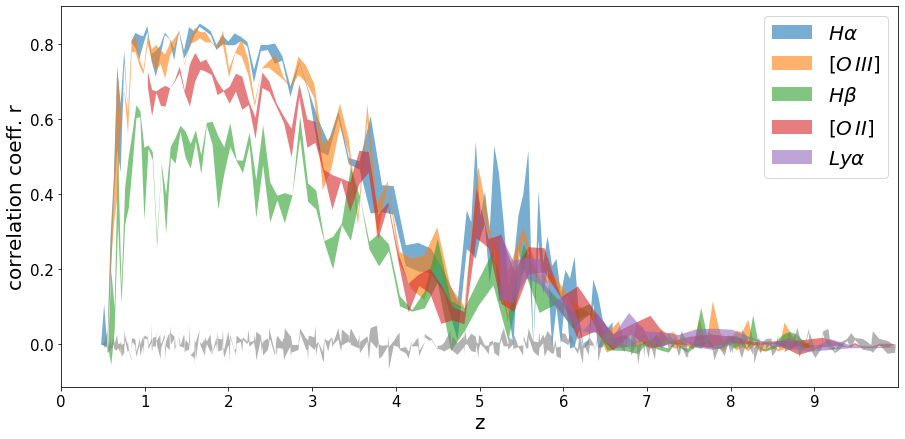

In [514]:
#
fig, ax = plt.subplots(1, 1, figsize = (15,7))

mucntot_arr = np.array([])
sigcntot_arr = np.array([])
ztot_arr = np.array([])
for jtarg in range(len(line_use)):
    nu0 = nu0_arr[jtarg]
    zbins = nu0 / sphx_par.nu_bins - 1
    sp = np.where(zbins < 10)[0]
    mucp_arr = np.zeros(N_nu)
    sigcp_arr = np.zeros(N_nu)
    mucn_arr = np.zeros(N_nu)
    sigcn_arr = np.zeros(N_nu)
    for iband in range(N_nu):
        cp_arr = np.zeros(Ipred_targ_arr.shape[0])
        cn_arr = np.zeros(Ipred_targ_arr.shape[0])
        for isim in range(Ipred_targ_arr.shape[0]):
            mapt = Itrue_targ[jtarg, :, iband]
            mapp = Ipred_targ_arr[isim, jtarg, :, iband]
            mapn = np.random.normal(size = mapt.shape)
            mapt -= np.mean(mapt)
            mapp -= np.mean(mapp)
            mapn -= np.mean(mapn)
            if np.sum(mapt**2) > 0 and np.sum(mapp**2) > 0:
                cp_arr[isim] = np.sum(mapt * mapp) / np.sqrt(np.sum(mapt**2) * np.sum(mapp**2))
            if np.sum(mapt**2) > 0 and np.sum(mapn**2) > 0:
                cn_arr[isim] = np.sum(mapt * mapn) / np.sqrt(np.sum(mapt**2) * np.sum(mapn**2))
        mucp_arr[iband] = np.mean(cp_arr)
        sigcp_arr[iband] = np.std(cp_arr)
        mucn_arr[iband] = np.mean(cn_arr)
        sigcn_arr[iband] = np.std(cn_arr)
        
    mucntot_arr = np.concatenate((mucntot_arr, mucn_arr[sp]))
    sigcntot_arr = np.concatenate((sigcntot_arr, sigcn_arr[sp]))
    ztot_arr = np.concatenate((ztot_arr, zbins[sp]))
    ax.fill_between(zbins[sp],mucp_arr[sp] - sigcp_arr[sp], mucp_arr[sp] + sigcp_arr[sp],\
                    label = line_name_arr[jtarg], alpha = 0.6)
sortidx = ztot_arr.argsort()
ax.fill_between(ztot_arr[sortidx], mucntot_arr[sortidx] - sigcntot_arr[sortidx],\
                mucntot_arr[sortidx] + sigcntot_arr[sortidx], alpha=0.6, facecolor='gray')
ax.legend(loc = 0, fontsize = 20)
ax.set_xlabel('z', fontsize = 20)
ax.set_xlim([0,10])
ax.set_ylabel(r'correlation coeff. r', fontsize = 20)
ax.set_xticks(np.arange(10))
ax.tick_params(axis='both', which='major', labelsize=15)

# plt.savefig('plots/paperfig/Full_r.pdf', bbox_inches = 'tight', dpi = 300)

# SLED Variations

In [7]:
# skip this cell, load the pickle
# ['Ha', 'OIII', 'Hb', 'OII', 'Lya']
N_true0, Itrue_all0, Itrue_targ0 = gen_lightcone(N_lc*4, dth, nu_binedges, z_coords_all, \
                      I_coords_all, z_idx, line_use, line_targ_vec, model = model,
                     sigL=[0,0.5,1,0.1,0.5]) 
N_true = N_true0[::4,:] + N_true0[1::4,:] + N_true0[2::4,:] + N_true0[3::4,:]
Itrue_all = (Itrue_all0[::4,:] + Itrue_all0[1::4,:] + Itrue_all0[2::4,:] + \
             Itrue_all0[3::4,:]) / 4
Itrue_targ = (Itrue_targ0[:,::4,:] + Itrue_targ0[:,1::4,:] +\
              Itrue_targ0[:,2::4,:] + Itrue_targ0[:,3::4,:]) / 4

with open('data_internal/sparse_be13_general_Lr.pickle','wb') as pfile:
    pickle.dump([N_true, Itrue_all, Itrue_targ], pfile)

In [8]:
with open('data_internal/sparse_be13_general_Lr.pickle','rb') as pfile:
    N_true, Itrue_all, Itrue_targ = pickle.load(pfile)

In [9]:
sigI0 = 3631 * 10**(-22  /2.5) / 5 / dOm / np.sqrt(4) # pixel NEI
sigI = sigI0 / np.sqrt(4)
e_th = sigI * 0.97

N_sim = 100
Ipred_targ_arr = np.zeros([N_sim]+list(Itrue_targ.shape))
for i in range(N_sim):
    Iobs_all = Itrue_all + np.random.normal(0, sigI, Itrue_all.shape)
    N_pred = run_MP(A, I_norm / 4, Iobs_all, e_th)
    _, Ipred_targ = gen_Ipred\
        (z_coords, N_pred, dth*2, nu_binedges, line_use, line_targ_vec, model = model, verbose = 0)
    Ipred_targ_arr[i] = Ipred_targ

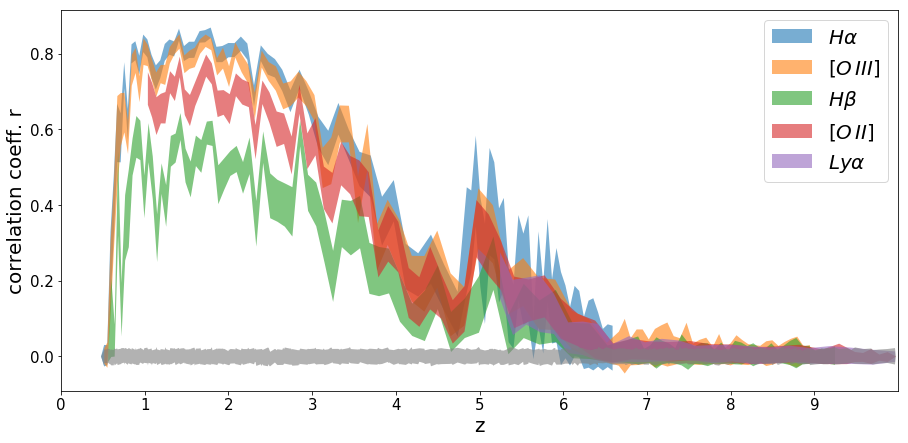

In [12]:
#
fig, ax = plt.subplots(1, 1, figsize = (15,7))

mucntot_arr = np.array([])
sigcntot_arr = np.array([])
ztot_arr = np.array([])
for jtarg in range(len(line_use)):
    nu0 = nu0_arr[jtarg]
    zbins = nu0 / sphx_par.nu_bins - 1
    sp = np.where(zbins < 10)[0]
    mucp_arr = np.zeros(N_nu)
    sigcp_arr = np.zeros(N_nu)
    mucn_arr = np.zeros(N_nu)
    sigcn_arr = np.zeros(N_nu)
    for iband in range(N_nu):
        cp_arr = np.zeros(Ipred_targ_arr.shape[0])
        cn_arr = np.zeros(Ipred_targ_arr.shape[0])
        for isim in range(Ipred_targ_arr.shape[0]):
            mapt = Itrue_targ[jtarg, :, iband]
            mapp = Ipred_targ_arr[isim, jtarg, :, iband]
            mapn = np.random.normal(size = mapt.shape)
            mapt = mapt - np.mean(mapt)
            mapp = mapp - np.mean(mapp)
            mapn = mapn - np.mean(mapn)
            if np.sum(mapt**2) > 0 and np.sum(mapp**2) > 0:
                cp_arr[isim] = np.sum(mapt * mapp) / np.sqrt(np.sum(mapt**2) * np.sum(mapp**2))
            if np.sum(mapt**2) > 0 and np.sum(mapn**2) > 0:
                cn_arr[isim] = np.sum(mapt * mapn) / np.sqrt(np.sum(mapt**2) * np.sum(mapn**2))
        mucp_arr[iband] = np.mean(cp_arr)
        sigcp_arr[iband] = np.std(cp_arr)
        mucn_arr[iband] = np.mean(cn_arr)
        sigcn_arr[iband] = np.std(cn_arr)
        
    mucntot_arr = np.concatenate((mucntot_arr, mucn_arr[sp]))
    sigcntot_arr = np.concatenate((sigcntot_arr, sigcn_arr[sp]))
    ztot_arr = np.concatenate((ztot_arr, zbins[sp]))
    ax.fill_between(zbins[sp],mucp_arr[sp] - sigcp_arr[sp], mucp_arr[sp] + sigcp_arr[sp],\
                    label = line_name_arr[jtarg], alpha = 0.6)
sortidx = ztot_arr.argsort()
ax.fill_between(ztot_arr[sortidx], mucntot_arr[sortidx] - sigcntot_arr[sortidx],\
                mucntot_arr[sortidx] + sigcntot_arr[sortidx], alpha=0.6, facecolor='gray')
ax.legend(loc = 0, fontsize = 20)
ax.set_xlabel('z', fontsize = 20)
ax.set_xlim([0,10])
ax.set_ylabel(r'correlation coeff. r', fontsize = 20)
ax.set_xticks(np.arange(10))
ax.tick_params(axis='both', which='major', labelsize=15)

plt.savefig('plots/paperfig/SPHEREx_r_var.pdf', bbox_inches = 'tight', dpi = 300)